## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_paca_pruned.pth
resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
pquant
data
smartpixels


In [3]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/tmp/ipykernel_431750/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


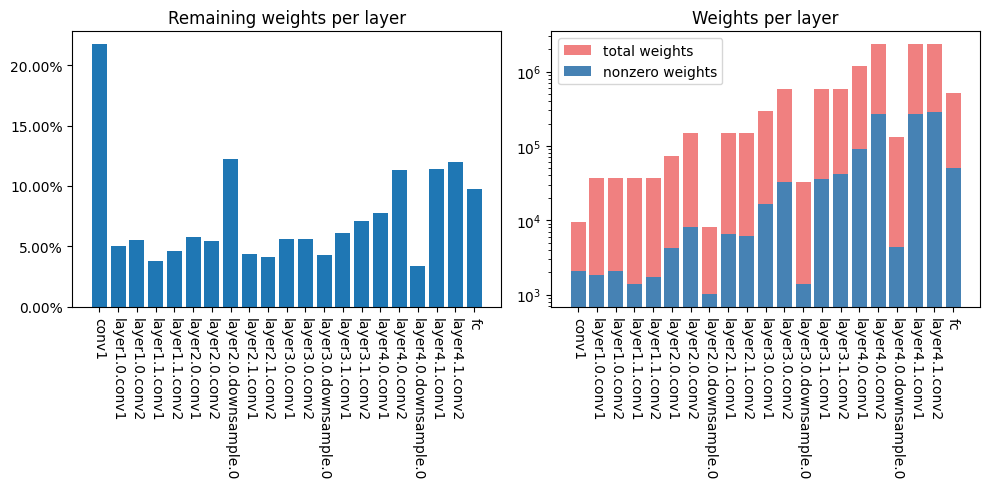

In [4]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
import keras
from keras import ops
import numpy as np
import torch # Keep for isinstance check


In [8]:
first_conv = model.conv1
print("First Conv Layer:", first_conv)
print("Weight shape:", first_conv.weight.shape)


First Conv Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Weight shape: torch.Size([64, 3, 7, 7])


In [28]:
# PyTorch: (out, in, kH, kW)
# Keras  : (kH, kW, in, out)

In [29]:
from functools import lru_cache

_AX = {"H": 0,   # kernel height  (kH)
       "W": 1,   # kernel width   (kW)
       "I": 2,   # input  channels (C_in)
       "O": 3}   # output channels (C_out)

def _layout_to_axes(layout: str):
    if len(layout) != 4 or set(layout) != set("HWIO"):
        raise ValueError("layout must be a permutation of 'HWIO'")
    return tuple(_AX[ch] for ch in layout)

@lru_cache(maxsize=None)
def _perm(src: str, dst: str):
    """
    Constant-time (cached) permutation tuple that reorders *src*→*dst*.
    """
    s = _layout_to_axes(src)
    d = _layout_to_axes(dst)
    return tuple(s.index(ax) for ax in d) 


def convert_conv_layout(w, src: str, dst: str = "HWIO"):
    if src == dst:
        return w                             
    perm = _perm(src, dst)                     # Python‑level, cached
    if perm == (0, 1, 2, 3):                   # identity permutation
        return w
    return ops.transpose(w, perm)

In [103]:
def get_kernels_and_patterns(w, src="OIHW"):
    # src:
    #   PyTorch: (out, in, kH, kW): OIHW
    #   Keras  : (kH, kW, in, out): HWIO
    w_permuted = convert_conv_layout(w, src="OIHW", dst="OIHW")
    C_out, C_in, kH, kW = ops.shape(w_permuted)
    kernels = ops.reshape(w_permuted, (C_out * C_in, -1))
    all_patterns = ops.cast(ops.not_equal(kernels, 0.0), dtype=w.dtype)

    return kernels, all_patterns, (C_out, C_in, kH, kW)


In [63]:
kernels, all_patterns, (C_out, C_in, kH, kW) =get_kernels_and_patterns(first_conv.weight)
print("Kernels shape:", kernels.shape)
print("Patterns shape:", all_patterns.shape)


torch.Size([192, 49])
Kernels shape: torch.Size([192, 49])
Patterns shape: torch.Size([192, 49])


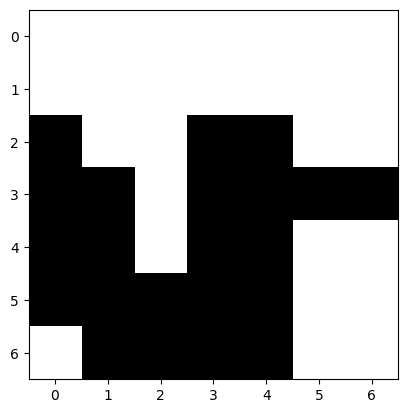

In [64]:
plt.imshow(all_patterns[3].reshape(7, 7).cpu().numpy(), cmap="binary", vmin=0, vmax=1)

In [65]:
def _get_unique_patterns_with_counts(all_patterns):
    """Returns the unique patterns and their counts."""
    np_patterns = ops.convert_to_numpy(all_patterns)
    uniq_np, counts_np = np.unique(np_patterns, axis=0, return_counts=True)

    unique_patterns = ops.convert_to_tensor(uniq_np, dtype=all_patterns.dtype)
    counts          = ops.convert_to_tensor(counts_np.astype("int32"), dtype="int32")
    return unique_patterns, counts

In [66]:
unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)

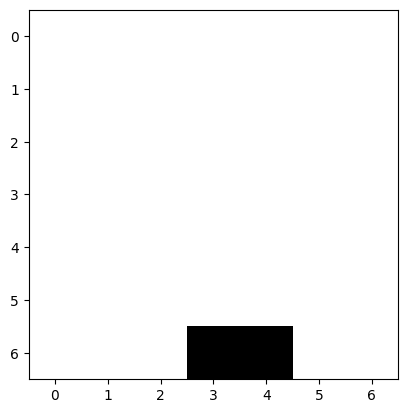

In [67]:
plt.imshow(unique_patterns[3].reshape(7, 7).cpu().numpy(), cmap="binary", vmin=0, vmax=1)

In [69]:
first_conv.weight.dtype

torch.float32

In [ ]:
def _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha, beta, dtype=None):
    """Selects the most frequent patterns based on alpha and beta."""
    if not dtype:
        raise ValueError("dtype must be provided")
    if ops.shape(unique_patterns)[0] == 0:
        return unique_patterns

    # ---------------- PDF ---------------------------------------------------
    total = ops.cast(ops.shape(all_patterns)[0], dtype)
    pdf   = ops.cast(counts, dtype) / total                     # (U,)

    # ---------------- sort by descending freq (single argsort) -------------
    order   = ops.argsort(-pdf)                                 # (U,)
    pdf_s   = ops.take(pdf, order)
    pat_s   = ops.take(unique_patterns, order, axis=0)

    # ---------------- CDF & first index >= beta -------------------------------
    cdf     = ops.cumsum(pdf_s)                                 # (U,)
    mask    = cdf >= beta                                       # (U,) bool
    has_hit = ops.any(mask)                                     # scalar bool

    # idx_first_true = argmax(mask)  (undefined if no True, but guarded)
    idx      = ops.argmax(mask)                                 # scalar int64
    n_beta   = ops.cast(idx + 1, counts.dtype)                  # scalar int32
    n_total  = ops.cast(ops.shape(cdf)[0], counts.dtype)

    # choose beta‑cut or full length
    keep_beta = ops.where(has_hit, n_beta, n_total)             # scalar int32
    keep      = ops.minimum(keep_beta, ops.cast(alpha, counts.dtype))

    return pat_s[:keep]                                         # (keep, K)

In [96]:
dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 8, beta = 0.75, dtype=first_conv.weight.dtype)

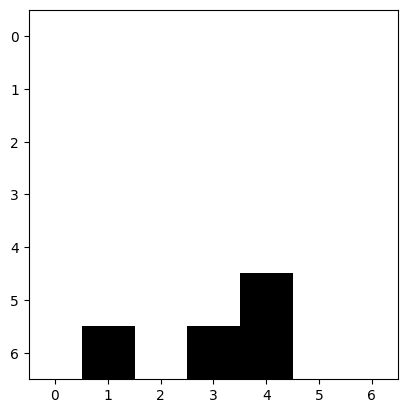

In [88]:
plt.imshow(dominant_patterns[7].reshape(7, 7).cpu().numpy(), cmap="binary", vmin=0, vmax=1)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from keras import ops


def plot_pattern_distributions(counts, dominant_patterns, layer_name = "conv1", log_scale1 = False, log_scale2 = False):
    counts_np  = ops.convert_to_numpy(counts)                # (U,)
    order      = np.argsort(-counts_np)                      # descending freq
    sorted_cnt = counts_np[order]

    n_keep     = dominant_patterns.shape[0]                  # M  <= alpha

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(np.arange(sorted_cnt.size), sorted_cnt, linewidth=0)
    if log_scale1: ax1.set_yscale("log")
    ax1.set_xlabel("Pattern rank (frequency ↓)")
    ax1.set_ylabel("Count")
    ax1.set_title(f"Pattern distribution – {layer_name}")
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    ax1.axvline(n_keep - 0.5, color="red", linestyle="--",
                label=f"kept = {n_keep}")
    ax1.legend()
    fig1.tight_layout()

    # -------------------------------------------------------------------------
    # 3.  Dominant‑only distribution
    # -------------------------------------------------------------------------
    dominant_cnt = sorted_cnt[:n_keep]

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.bar(np.arange(n_keep), dominant_cnt, color="tab:orange", linewidth=0)
    if log_scale2: ax2.set_yscale("log")
    ax2.set_xlabel("Dominant pattern index (0‥M‑1)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"Dominant patterns – {layer_name}")
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    fig2.tight_layout()

    plt.show()


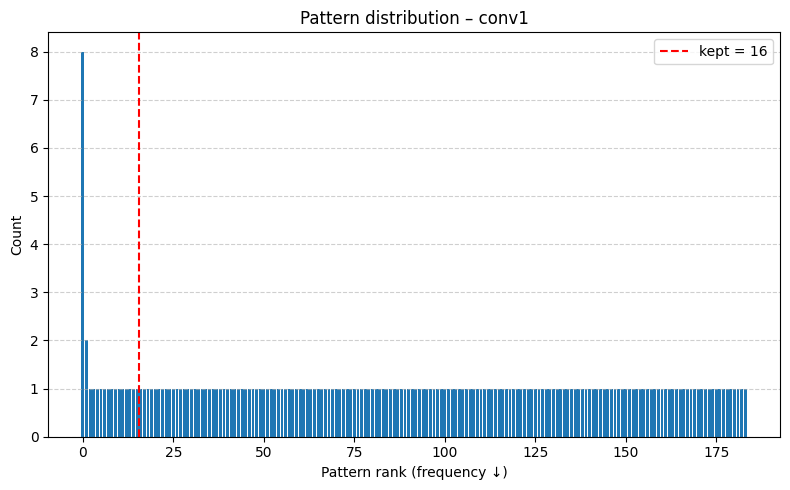

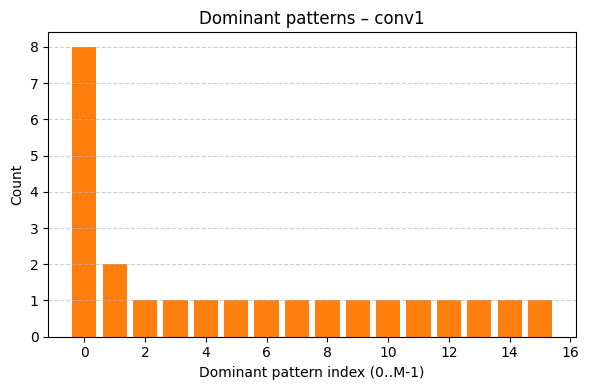

In [113]:
layer = model.conv1

kernels, all_patterns, (C_out, C_in, kH, kW) =get_kernels_and_patterns(layer.weight)
unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=layer.weight.dtype)

plot_pattern_distributions(counts, dominant_patterns, layer_name = "conv1", log_scale1 = False, log_scale2 = False)

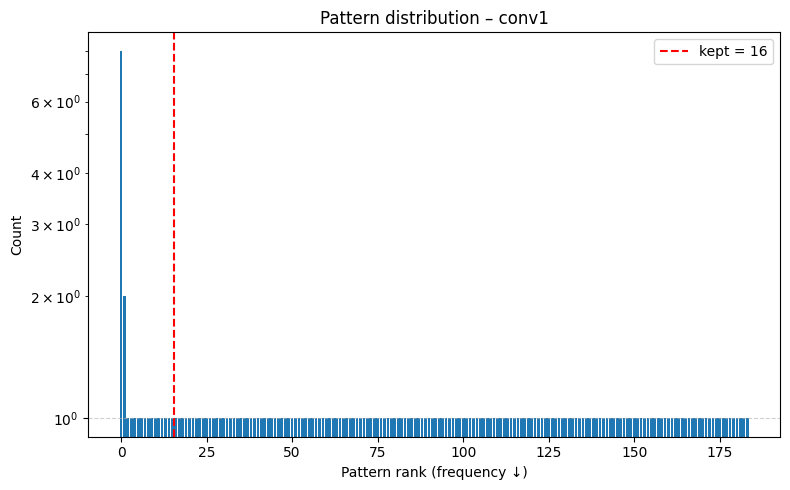

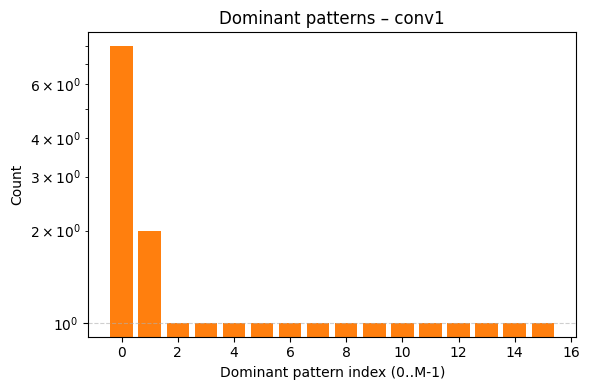

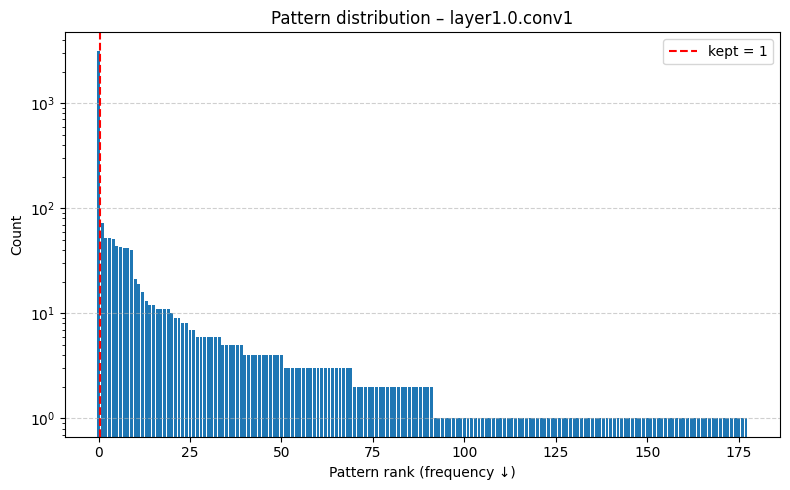

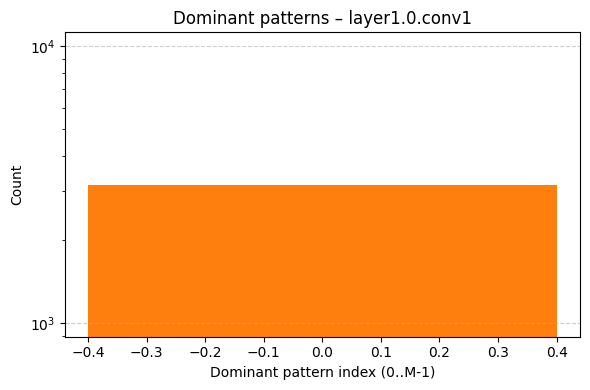

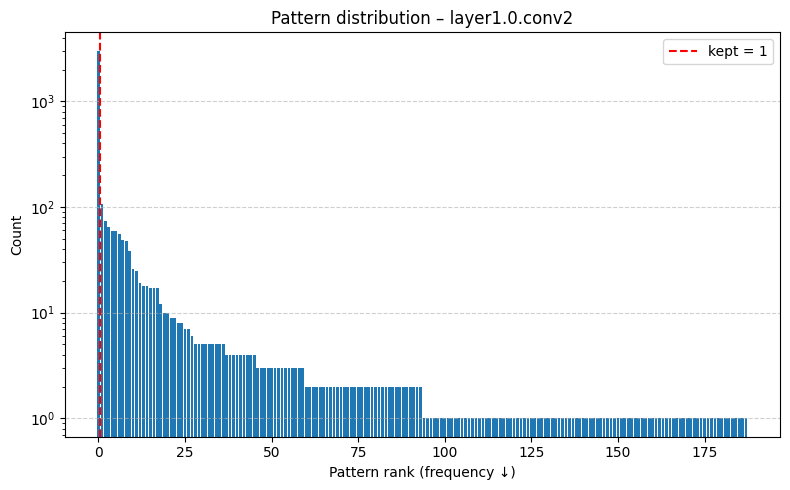

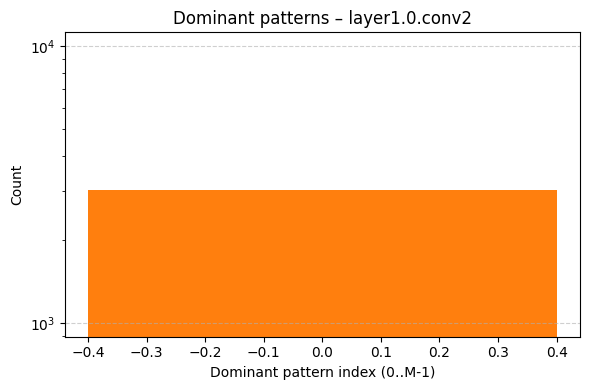

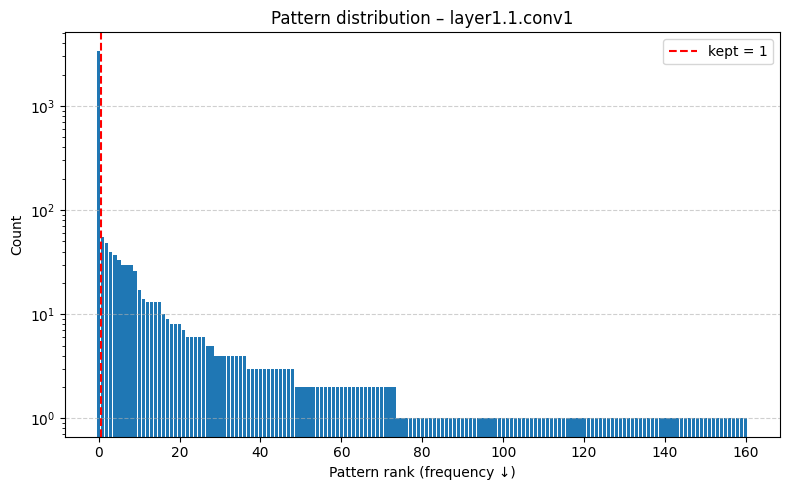

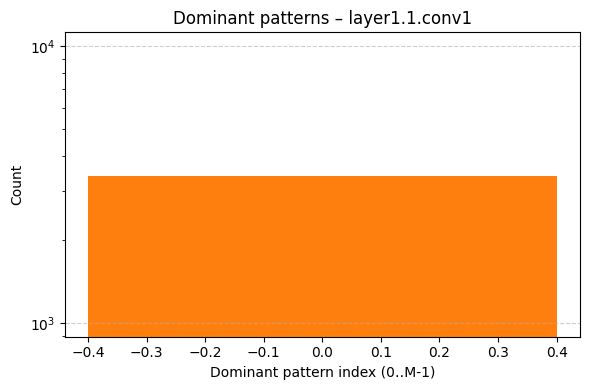

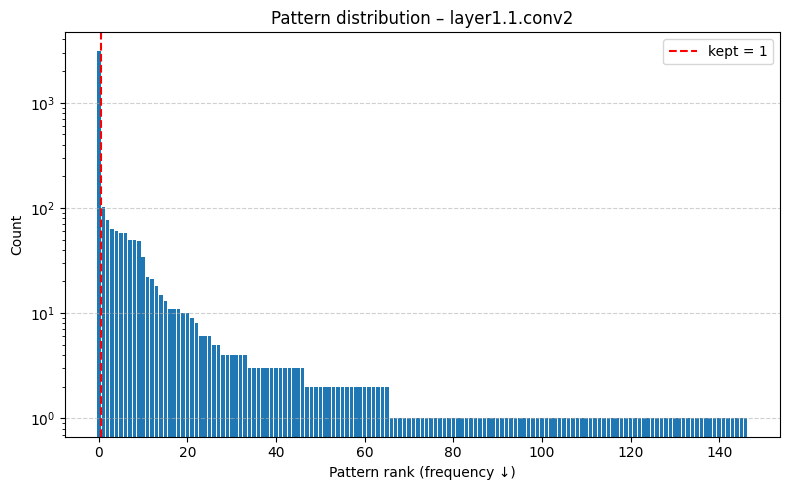

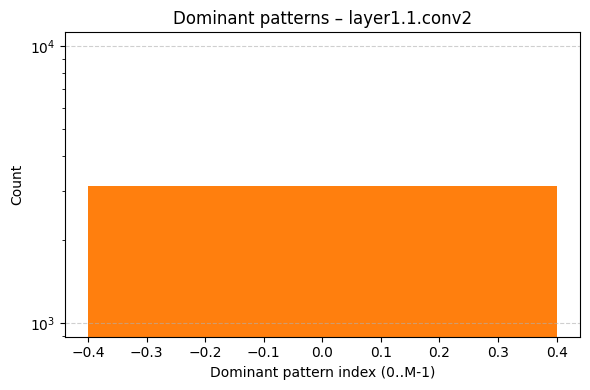

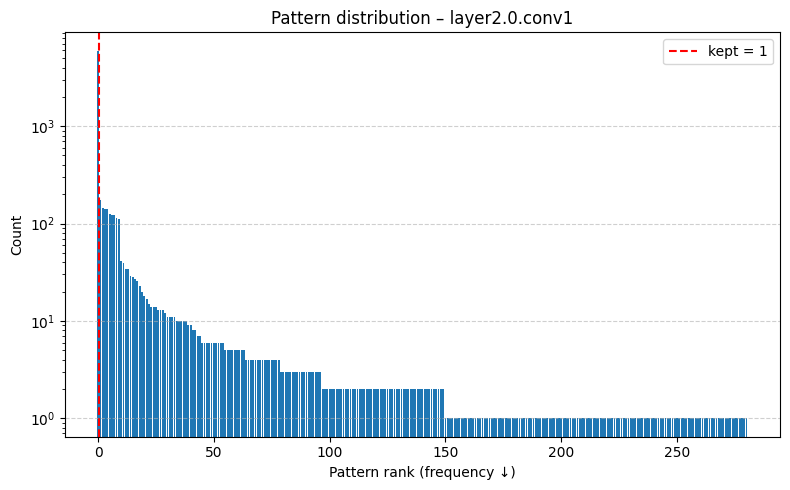

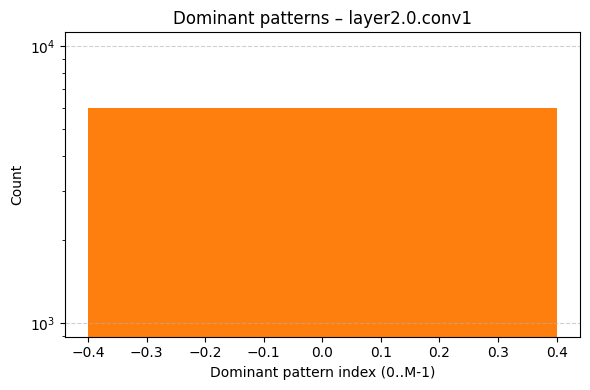

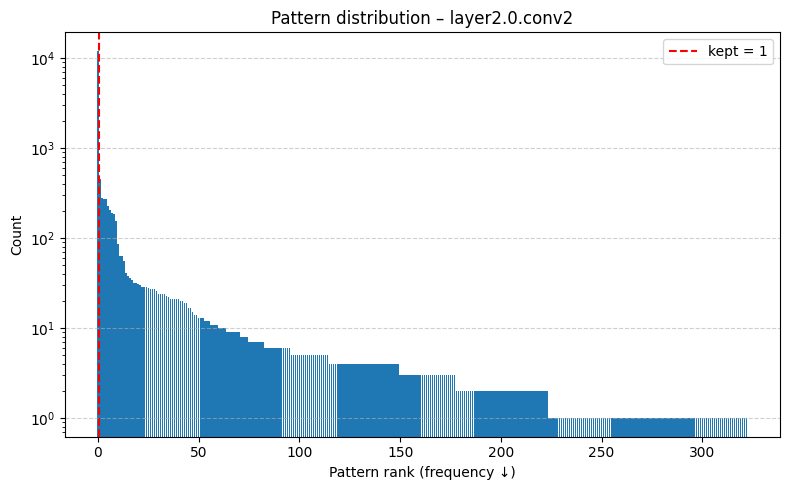

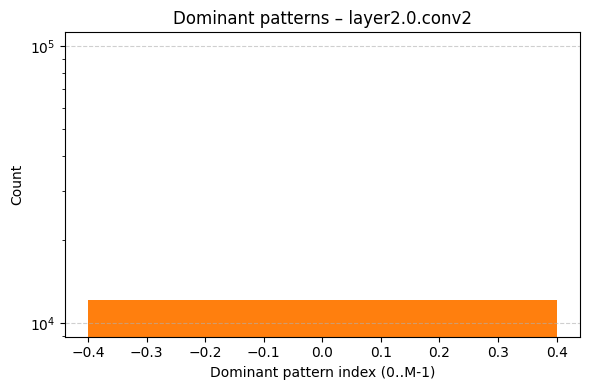

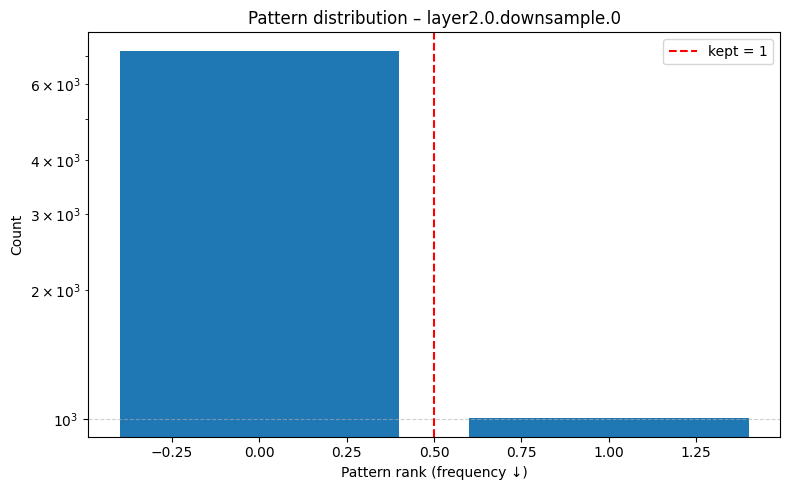

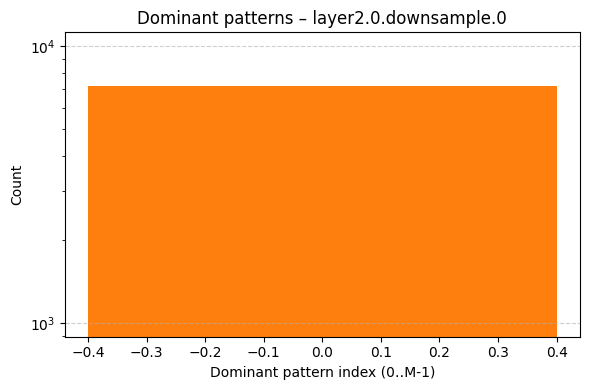

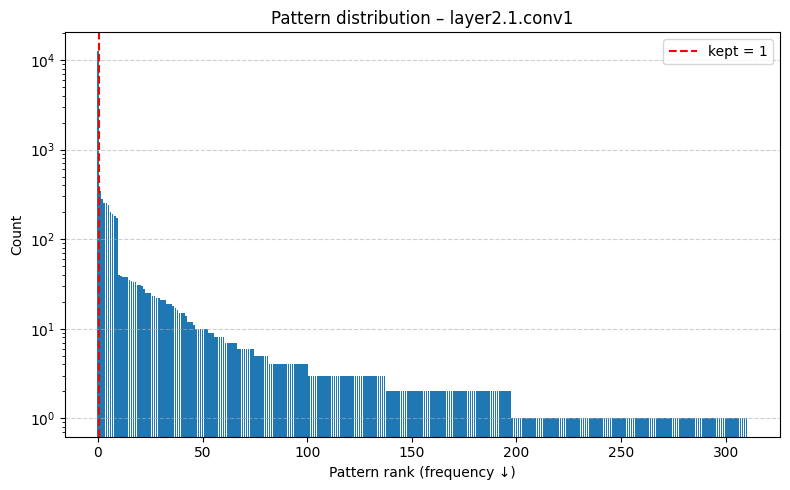

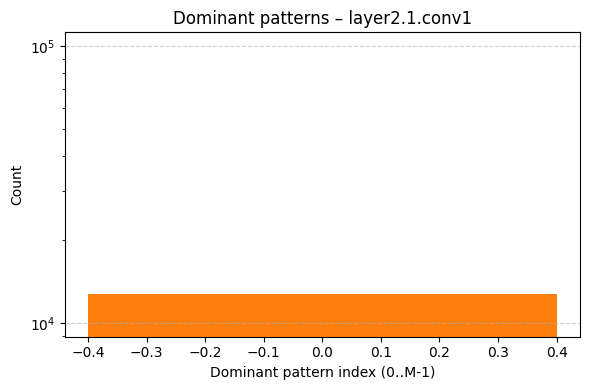

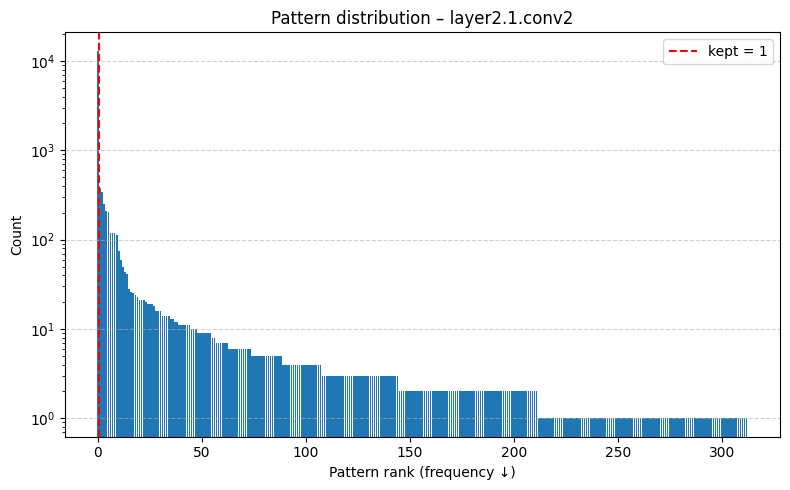

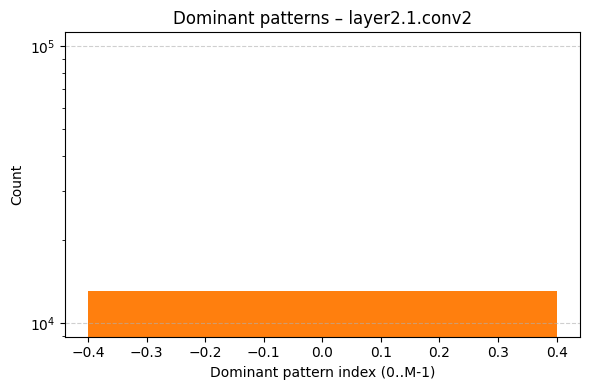

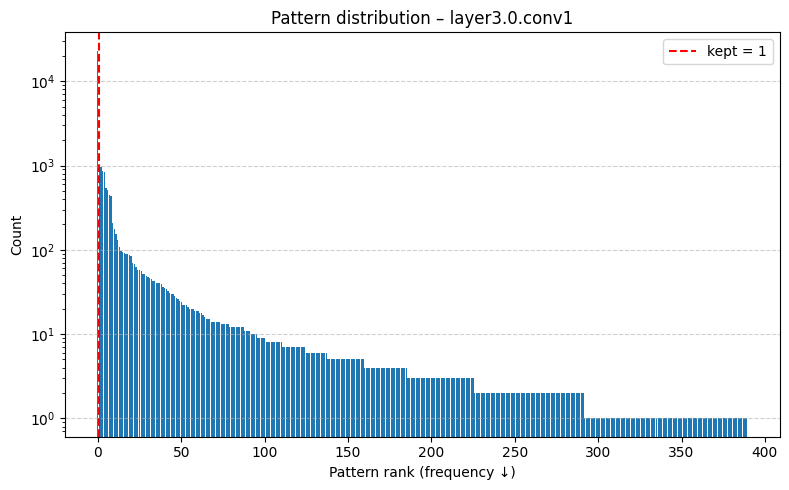

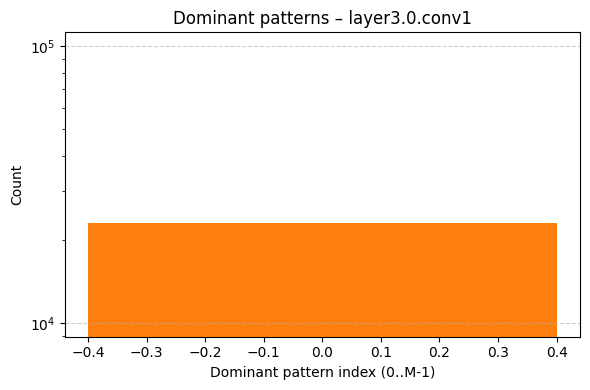

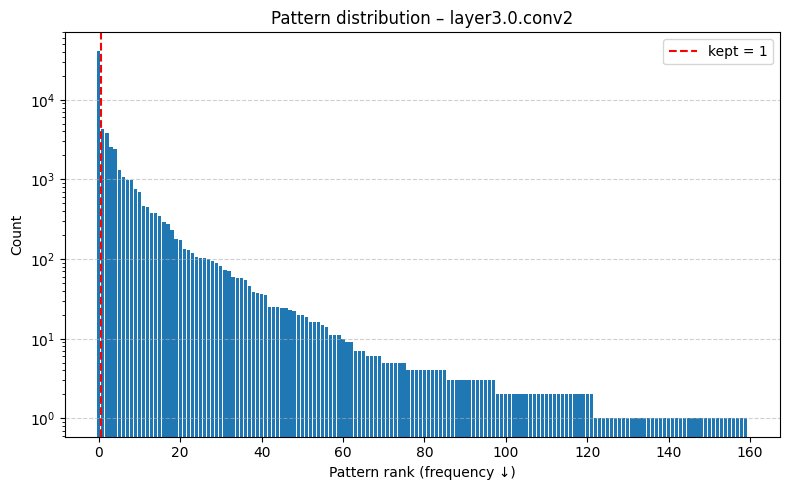

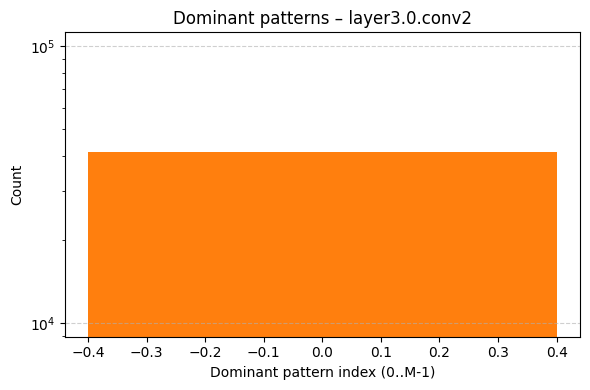

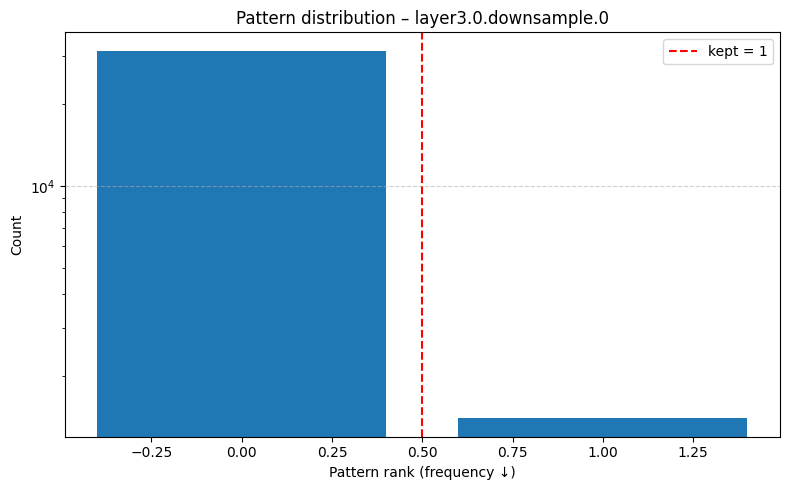

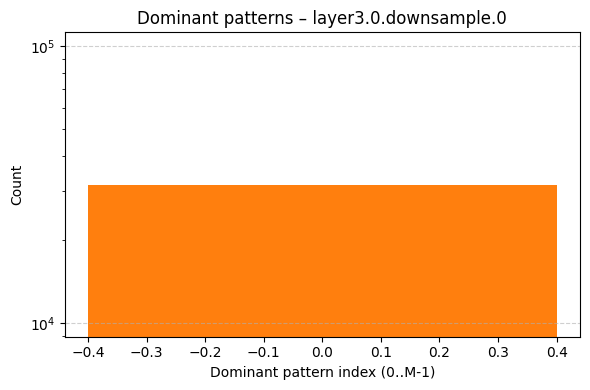

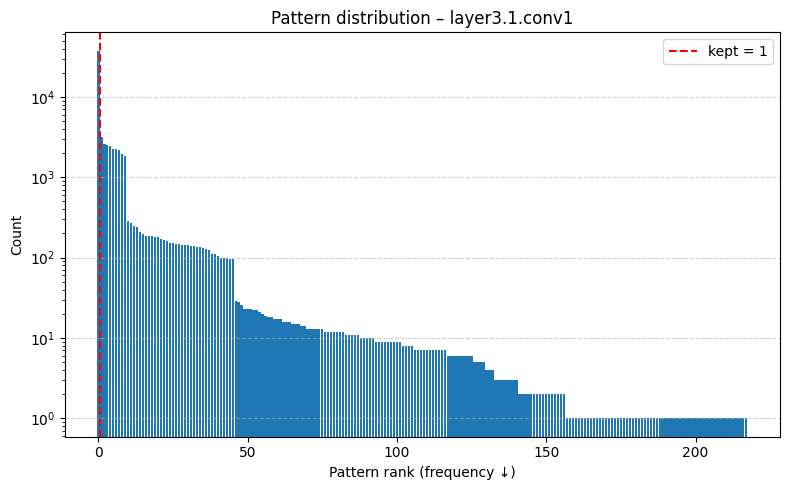

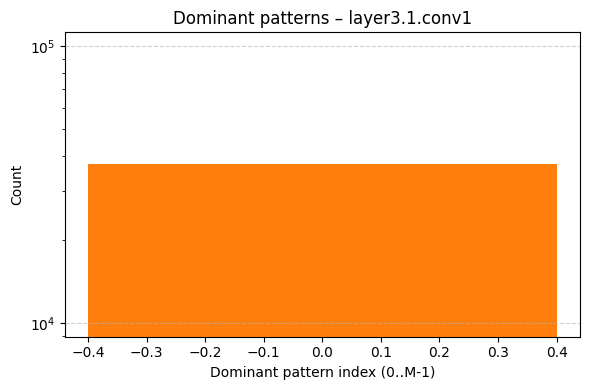

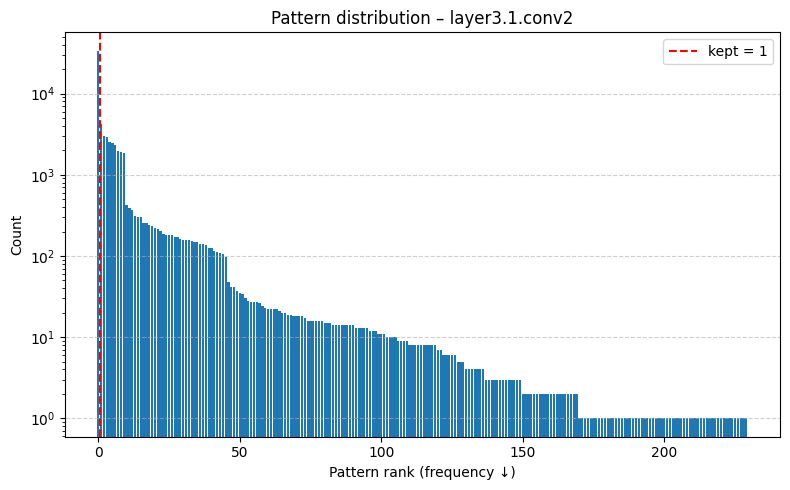

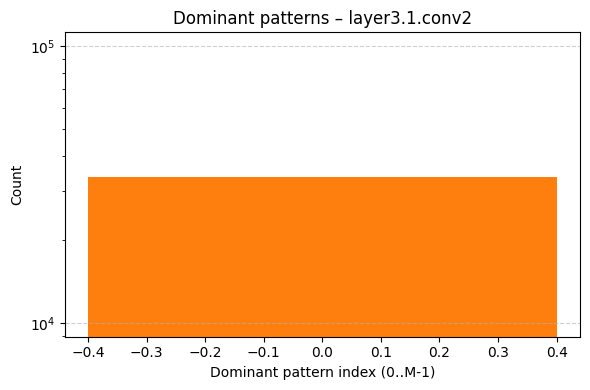

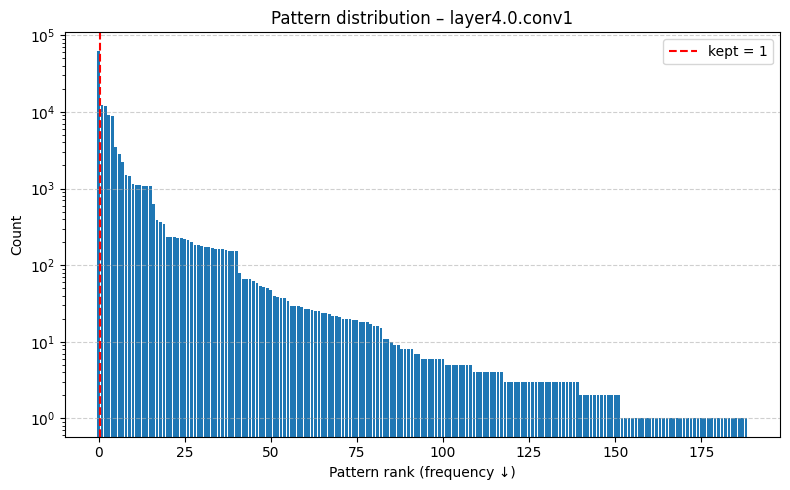

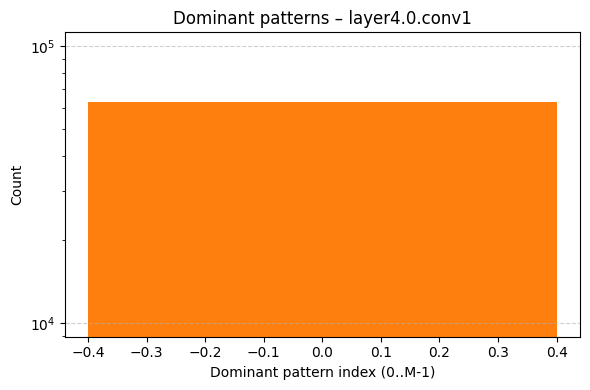

In [ ]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =get_kernels_and_patterns(module.weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = True, log_scale2 = True)

In [ ]:


# ==============================================================================
# 1. Core Logic Functions (Mirrors of PACAPatternMetric methods)
# ==============================================================================

def get_kernels_and_patterns(weight_tensor):
    """
    Extracts kernels and their binary patterns from a weight tensor.
    Assumes a consistent layout of (out_channels, in_channels, kH, kW).
    """
    # Note: Keras Conv2D weights are (kH, kW, in, out).
    # The calling function must handle the transpose.
    # This function expects (out, in, kH, kW).
    out_channels = ops.shape(weight_tensor)[0]
    kernels = ops.reshape(weight_tensor, (out_channels, -1))
    patterns = ops.cast(kernels != 0, dtype=weight_tensor.dtype)
    return kernels, patterns

def get_unique_patterns_with_counts(all_patterns):
    """
    Finds unique binary patterns and their counts using keras.ops.
    This is the exact backend-agnostic logic from the class.
    """
    if ops.shape(all_patterns)[0] == 0:
        return ops.convert_to_tensor([], dtype=all_patterns.dtype), ops.convert_to_tensor([], dtype='int32')

    num_bits = ops.shape(all_patterns)[1]
    pow_dtype = 'float64' if num_bits > 31 else 'int64'
    powers_of_2 = ops.power(2.0, ops.arange(num_bits, dtype=pow_dtype))
    hashes = ops.sum(all_patterns * ops.cast(powers_of_2, all_patterns.dtype), axis=1)

    sorted_indices = ops.argsort(hashes)
    sorted_hashes = ops.take(hashes, sorted_indices)
    sorted_patterns = ops.take(all_patterns, sorted_indices, axis=0)

    is_different = ops.not_equal(sorted_hashes[:-1], sorted_hashes[1:])
    boundary_indices = ops.cast(ops.where(is_different), dtype="int32")
    boundary_indices = ops.reshape(boundary_indices, [-1])

    unique_indices = ops.pad(boundary_indices + 1, [[1, 0]], constant_values=0)
    unique_patterns = ops.take(sorted_patterns, unique_indices, axis=0)

    full_boundaries = ops.pad(boundary_indices, [[1, 0]], constant_values=-1)
    full_boundaries = ops.pad(full_boundaries, [[0, 1]], constant_values=ops.shape(sorted_hashes)[0] - 1)
    counts = full_boundaries[1:] - full_boundaries[:-1]

    return unique_patterns, counts

# ==============================================================================
# 2. Main Analysis Function (Using the Core Logic)
# ==============================================================================

def extract_conv_patterns(model):
    """
    Extracts unique binary patterns from a model's convolutional layers
    using the standalone, backend-agnostic utility functions.
    """
    patterns_by_layer = {}
    backend = keras.backend.backend()
    
    # Use a device-agnostic approach
    if backend == "torch":
        try:
            device = next(model.parameters()).device
            model.cpu()
        except StopIteration:
            device = 'cpu' # Model has no parameters
        modules = model.named_modules()
    else:
        modules = [(layer.name, layer) for layer in model.layers]

    for name, module in modules:
        is_conv_layer = False
        weight_tensor = None

        if backend == "torch" and isinstance(module, torch.nn.Conv2d):
            if hasattr(module, 'weight') and module.weight is not None:
                # PyTorch format is already (out, in, kH, kW)
                weight_tensor = ops.convert_to_tensor(module.weight.detach())
                is_conv_layer = len(weight_tensor.shape) == 4
        elif backend != "torch" and isinstance(module, keras.layers.Conv2D):
            # TensorFlow/Keras format is (kH, kW, in, out)
            # Transpose to the consistent (out, in, kH, kW) layout
            weight_tensor = ops.transpose(module.kernel, (3, 0, 1, 2))
            is_conv_layer = True

        if is_conv_layer:
            # The weight tensor is now in the consistent (out, in, kH, kW) layout
            kernel_h, kernel_w = weight_tensor.shape[2], weight_tensor.shape[3]
            
            # Use the core utility functions
            _, all_patterns = get_kernels_and_patterns(weight_tensor)
            unique_patterns, counts = get_unique_patterns_with_counts(all_patterns)
            
            if ops.shape(unique_patterns)[0] == 0:
                continue

            # Sort results by frequency for reporting
            count_sort_indices_asc = ops.argsort(counts)
            count_sort_indices = ops.flip(count_sort_indices_asc, axis=0)

            sorted_unique_patterns = ops.take(unique_patterns, count_sort_indices, axis=0)
            sorted_counts = ops.take(counts, count_sort_indices)

            # Store the results as numpy arrays for easy plotting/analysis
            patterns_by_layer[name] = {
                'patterns': ops.convert_to_numpy(sorted_unique_patterns),
                'counts': ops.convert_to_numpy(sorted_counts),
                'kernel_shape': (kernel_h, kernel_w)
            }
            print(f"Processed layer '{name}', found {len(sorted_counts)} unique patterns.")

    # Restore model to original device
    if backend == "torch" and 'device' in locals() and device != 'cpu':
        model.to(device)
        
    return patterns_by_layer

In [37]:
import math

def plot_pattern_distribution(layer_name, pattern_data):
    """
    Creates a histogram showing the distribution of pattern frequencies.

    Returns: A matplotlib Figure object for saving.
    """
    counts = pattern_data['counts']
    num_unique_patterns = len(counts)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(num_unique_patterns), counts, color='steelblue')
    
    ax.set_title(f"Pattern Distribution for Layer: {layer_name}", fontsize=16)
    ax.set_xlabel("Pattern Index (Sorted by Frequency)")
    ax.set_ylabel("Frequency (Count)")
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    return fig

def plot_dominant_patterns(layer_name, pattern_data, max_patterns_to_show=16):
    """
    Creates a grid visualization of the most dominant binary patterns.

    Returns: A matplotlib Figure object for saving.
    """
    patterns = pattern_data['patterns']
    kernel_h, kernel_w = pattern_data['kernel_shape']
    num_to_show = min(len(patterns), max_patterns_to_show)

    cols = math.ceil(math.sqrt(num_to_show))
    rows = math.ceil(num_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2.2))
    axes = np.array(axes).flatten()

    fig.suptitle(f"Dominant Patterns for Layer: {layer_name}", fontsize=16)

    for i in range(num_to_show):
        pattern_2d = patterns[i].reshape(kernel_h, kernel_w)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1, interpolation='nearest')
        axes[i].set_title(f"Pattern #{i+1}\n(Count: {pattern_data['counts'][i]})")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Hide unused subplots
    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [50]:
all_patterns = extract_conv_patterns(model)

Processed layer 'conv1', found 64 unique patterns.
Processed layer 'layer1.0.conv1', found 64 unique patterns.
Processed layer 'layer1.0.conv2', found 64 unique patterns.
Processed layer 'layer1.1.conv1', found 64 unique patterns.
Processed layer 'layer1.1.conv2', found 64 unique patterns.
Processed layer 'layer2.0.conv1', found 128 unique patterns.
Processed layer 'layer2.0.conv2', found 128 unique patterns.
Processed layer 'layer2.0.downsample.0', found 118 unique patterns.
Processed layer 'layer2.1.conv1', found 128 unique patterns.
Processed layer 'layer2.1.conv2', found 128 unique patterns.
Processed layer 'layer3.0.conv1', found 256 unique patterns.
Processed layer 'layer3.0.conv2', found 256 unique patterns.
Processed layer 'layer3.0.downsample.0', found 160 unique patterns.
Processed layer 'layer3.1.conv1', found 256 unique patterns.
Processed layer 'layer3.1.conv2', found 256 unique patterns.
Processed layer 'layer4.0.conv1', found 512 unique patterns.
Processed layer 'layer4.

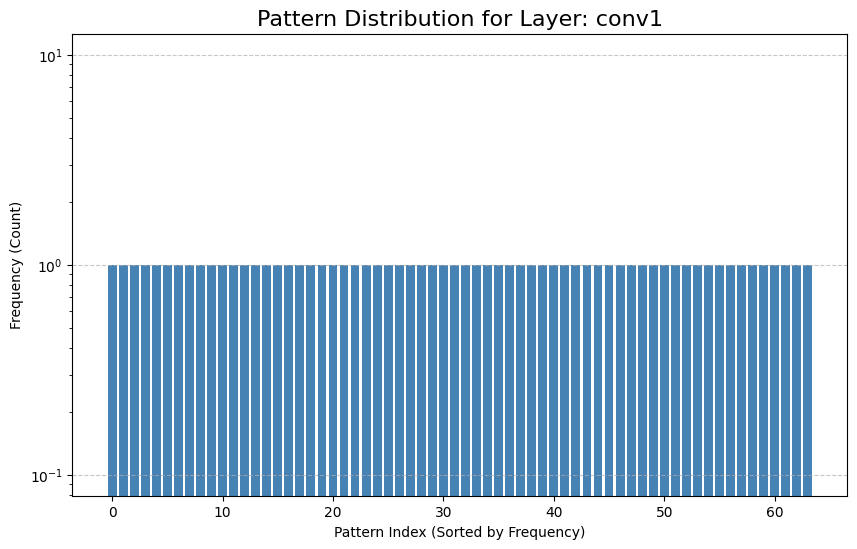

ValueError: cannot reshape array of size 147 into shape (7,7)

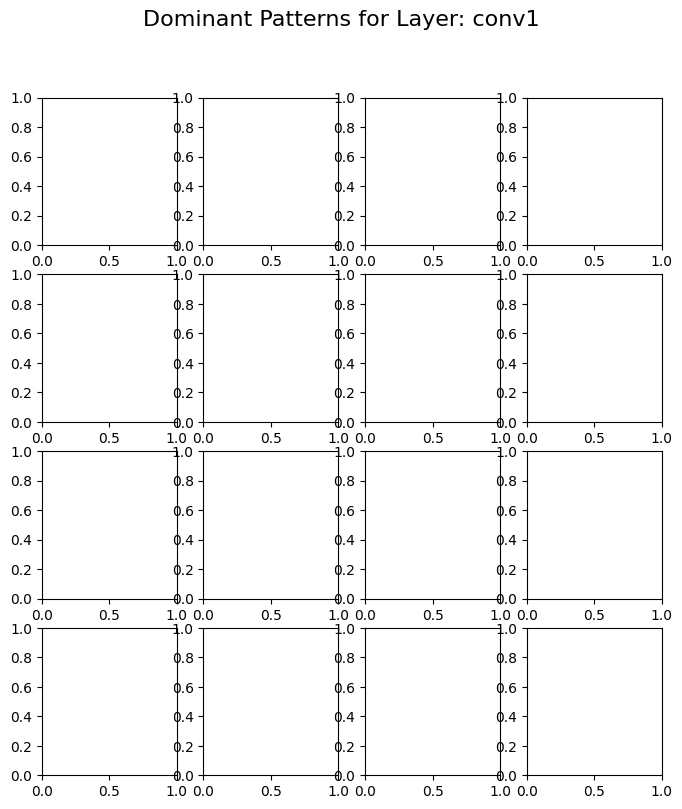

In [51]:
for layer_name, data in all_patterns.items():
    fig_hist = plot_pattern_distribution(layer_name, data)
    plt.show()
    
    fig_patterns = plot_dominant_patterns(layer_name, data)
    plt.show()

In [43]:
SAVE_PATH = 'resnet_mdmm_unstr_paca_pruned.pth'

model_paca = torchvision.models.resnet18()
model_paca.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [44]:
all_patterns = extract_conv_patterns(model_paca)


Processed layer 'conv1', found 64 unique patterns.
Processed layer 'layer1.0.conv1', found 64 unique patterns.
Processed layer 'layer1.0.conv2', found 64 unique patterns.
Processed layer 'layer1.1.conv1', found 64 unique patterns.
Processed layer 'layer1.1.conv2', found 64 unique patterns.
Processed layer 'layer2.0.conv1', found 128 unique patterns.
Processed layer 'layer2.0.conv2', found 128 unique patterns.
Processed layer 'layer2.0.downsample.0', found 118 unique patterns.
Processed layer 'layer2.1.conv1', found 128 unique patterns.
Processed layer 'layer2.1.conv2', found 128 unique patterns.
Processed layer 'layer3.0.conv1', found 256 unique patterns.
Processed layer 'layer3.0.conv2', found 256 unique patterns.
Processed layer 'layer3.0.downsample.0', found 160 unique patterns.
Processed layer 'layer3.1.conv1', found 256 unique patterns.
Processed layer 'layer3.1.conv2', found 256 unique patterns.
Processed layer 'layer4.0.conv1', found 512 unique patterns.
Processed layer 'layer4.

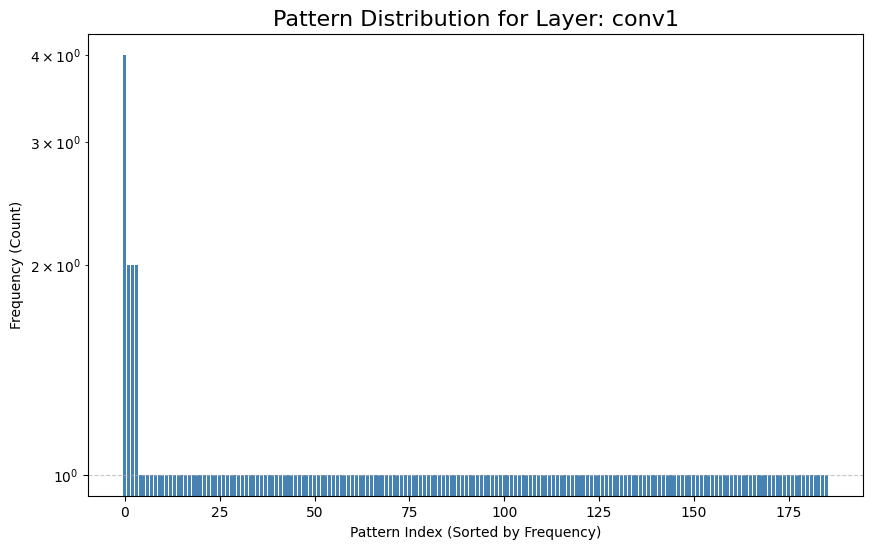

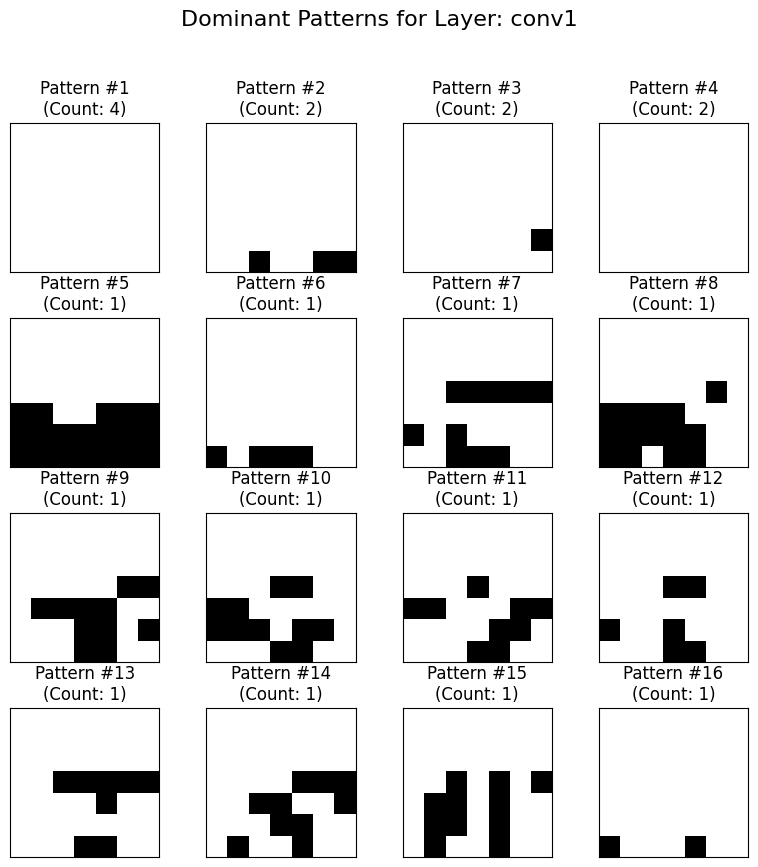

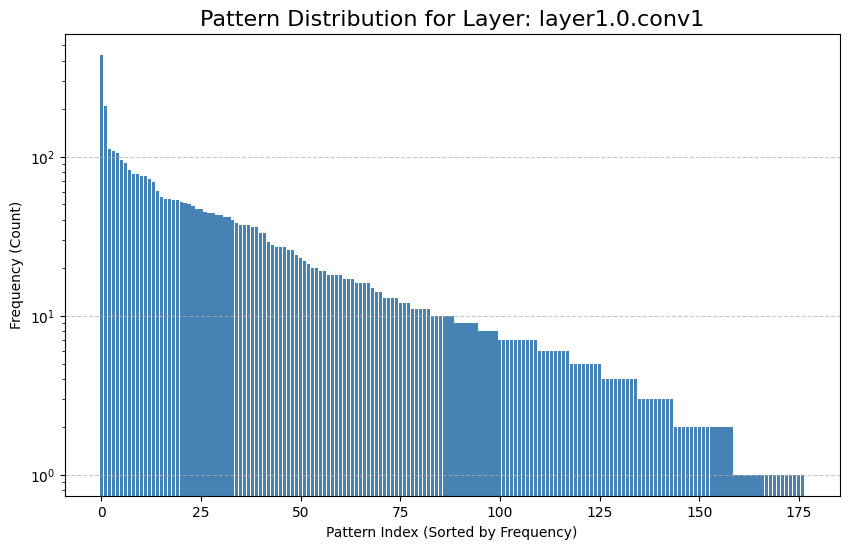

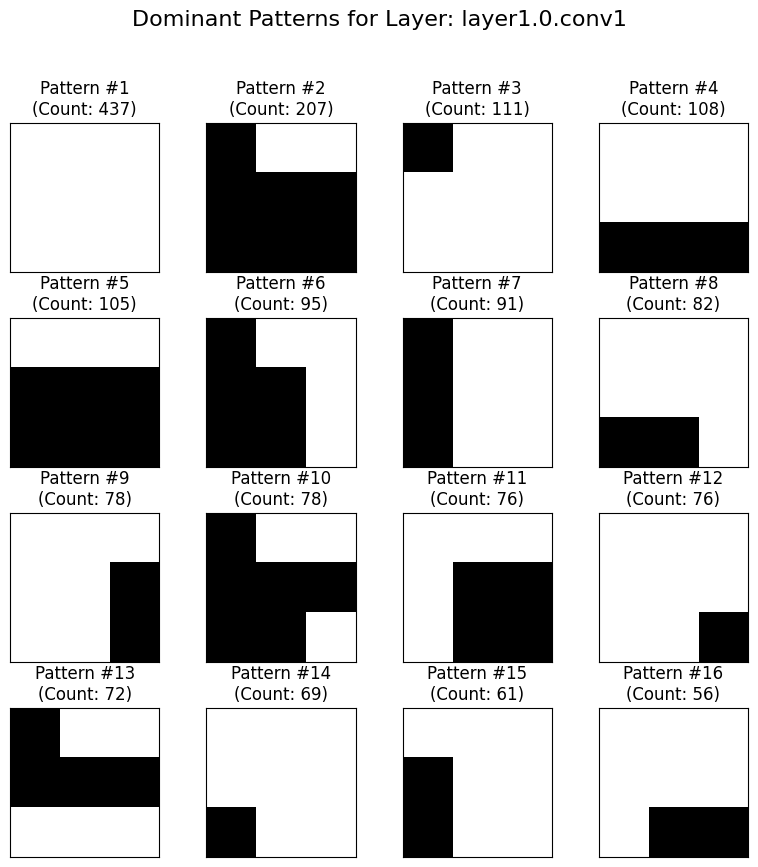

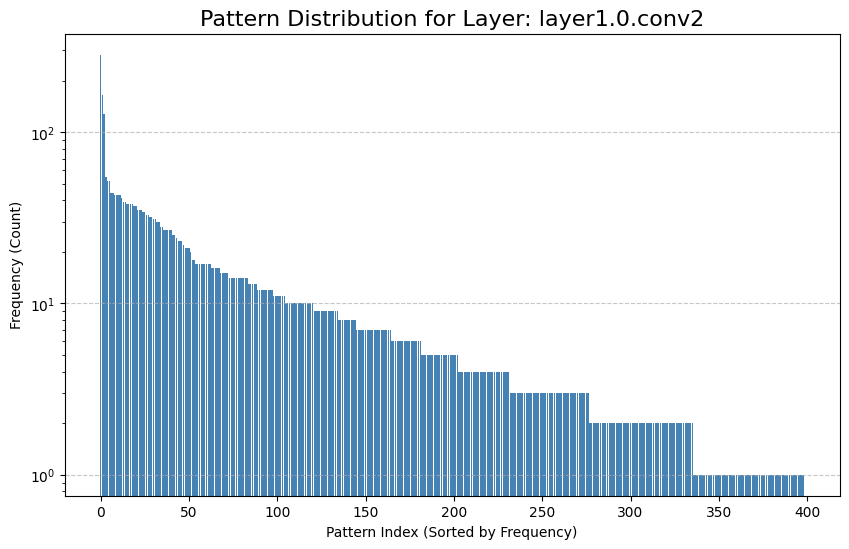

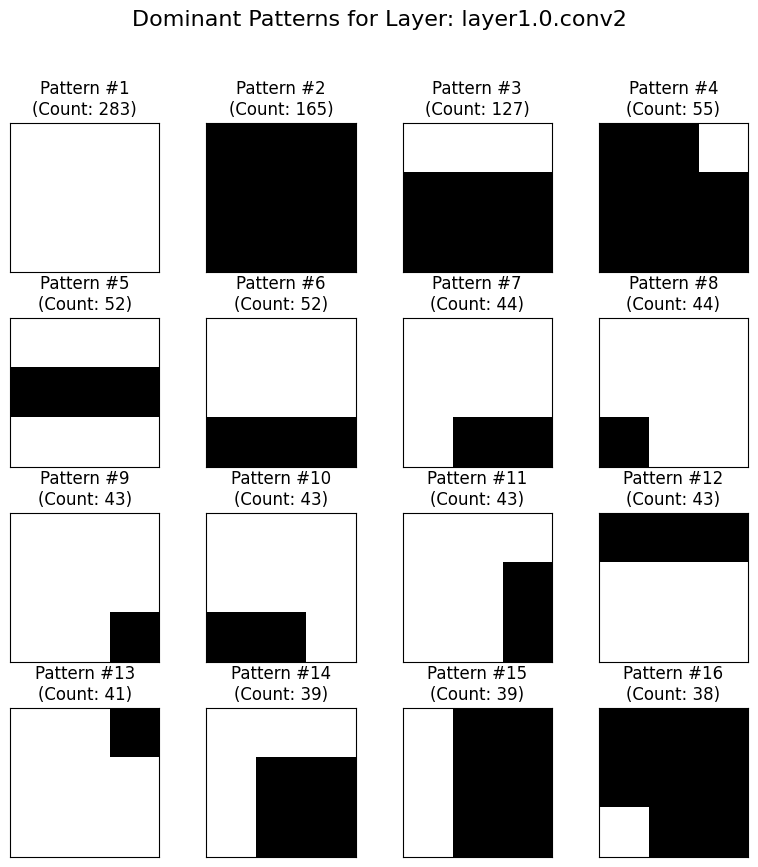

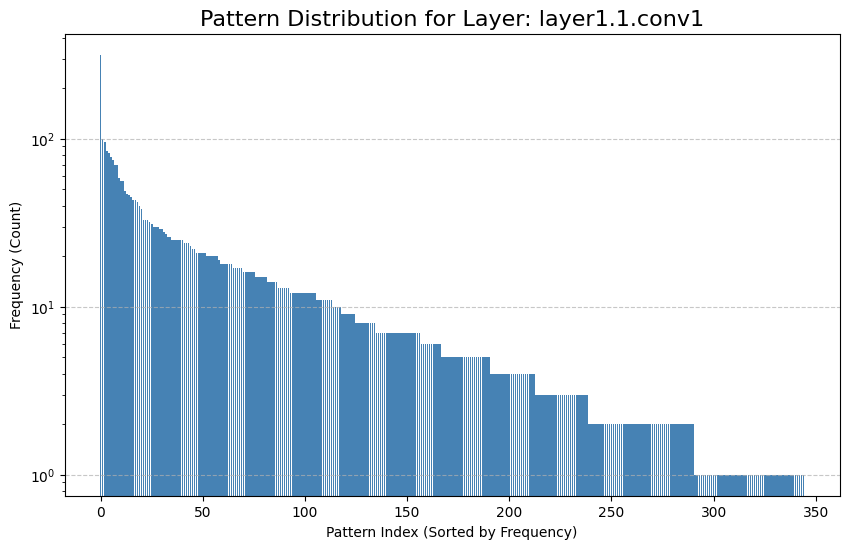

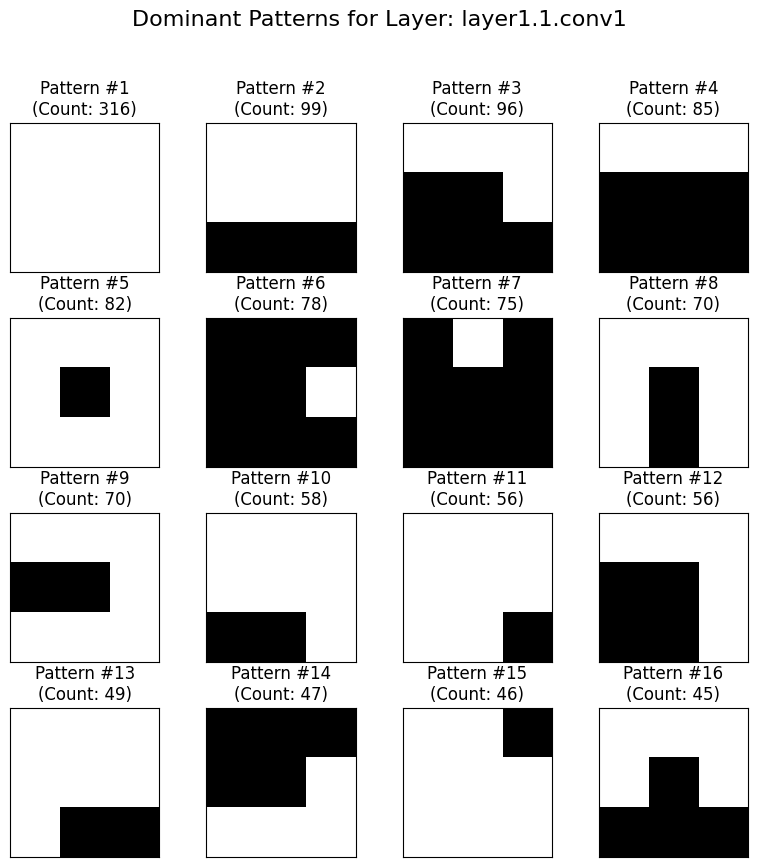

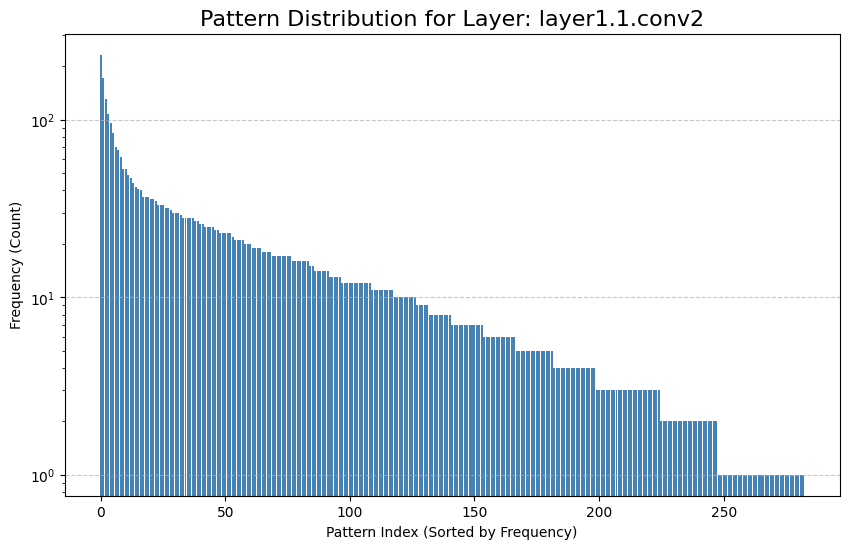

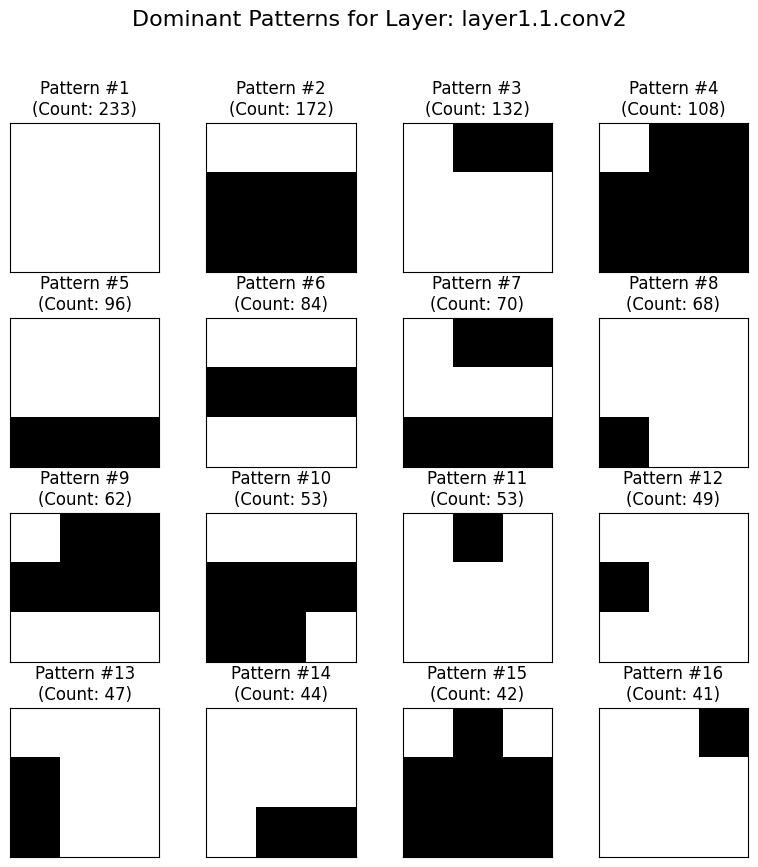

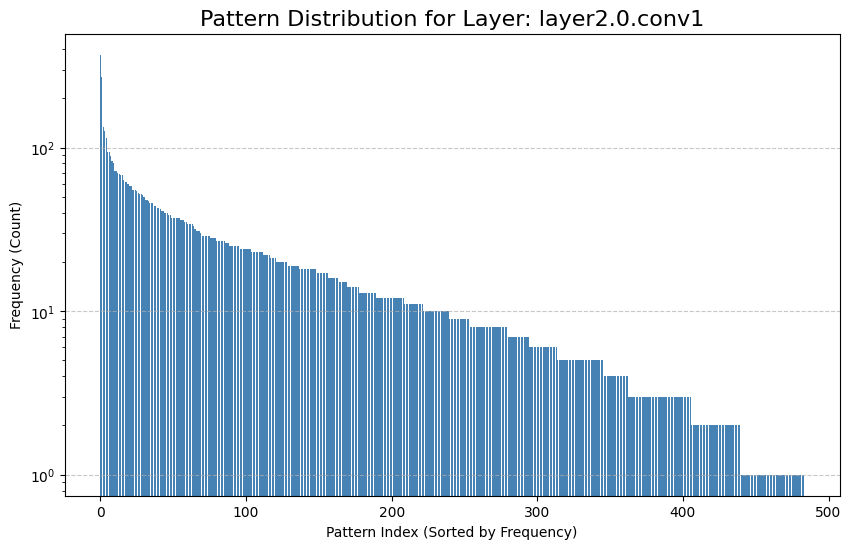

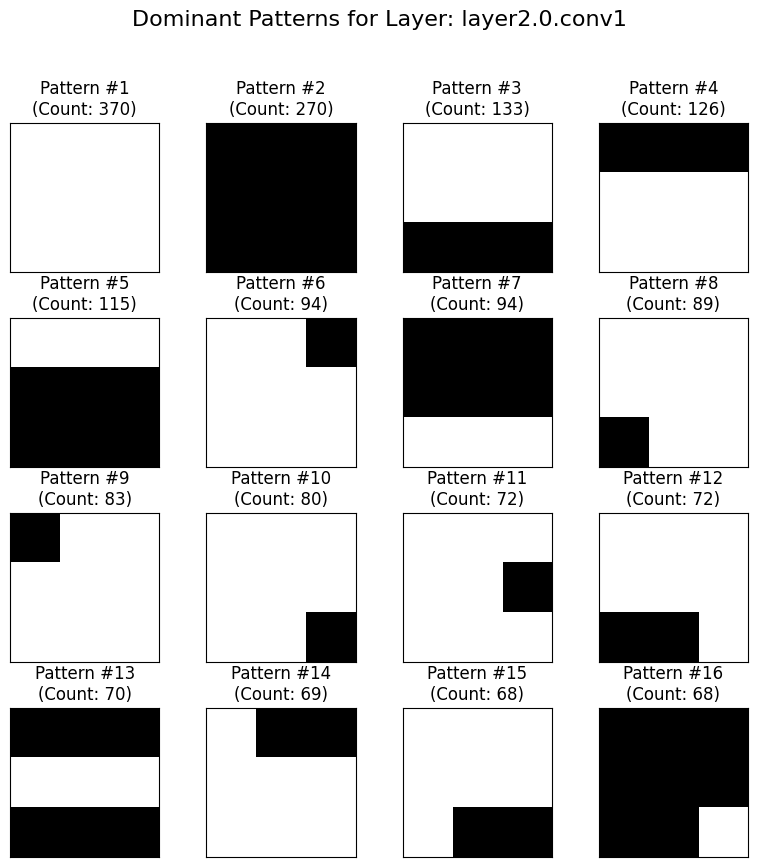

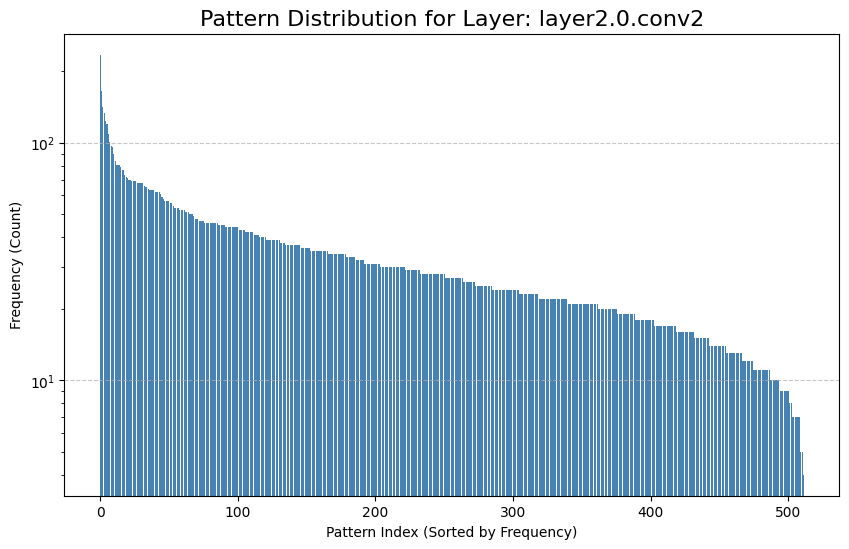

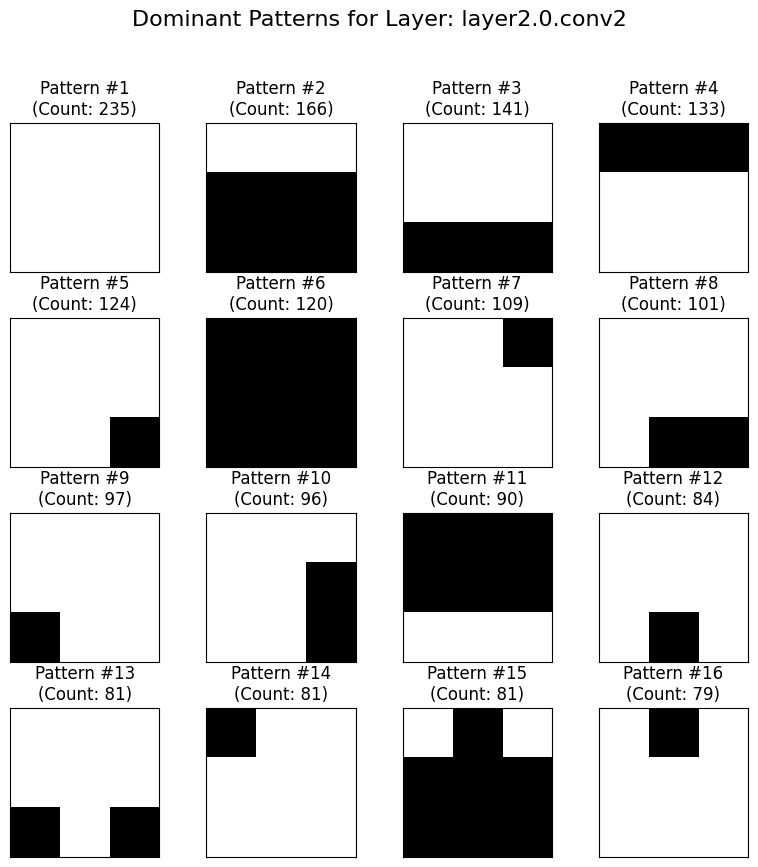

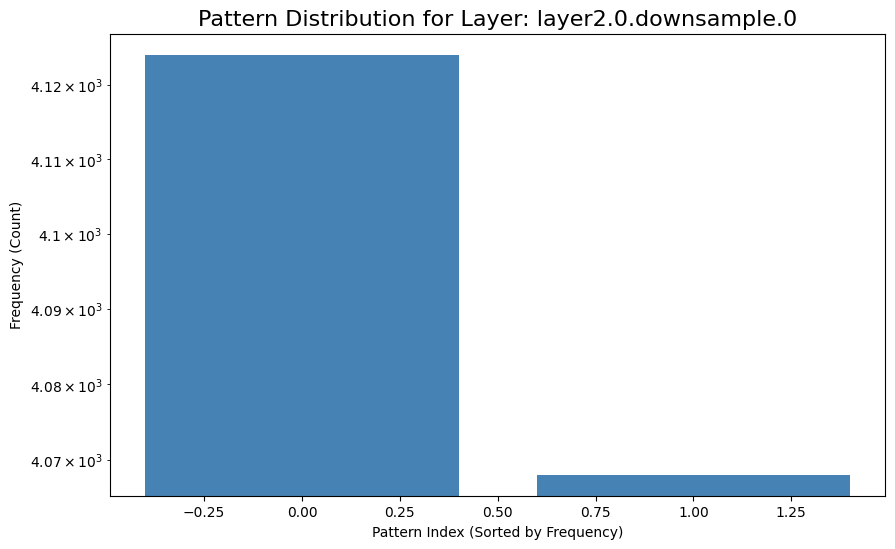

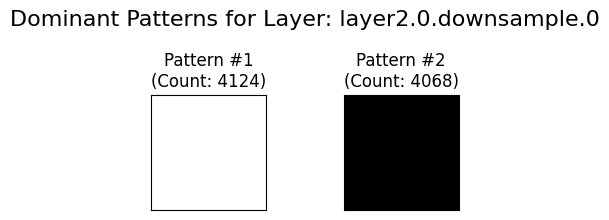

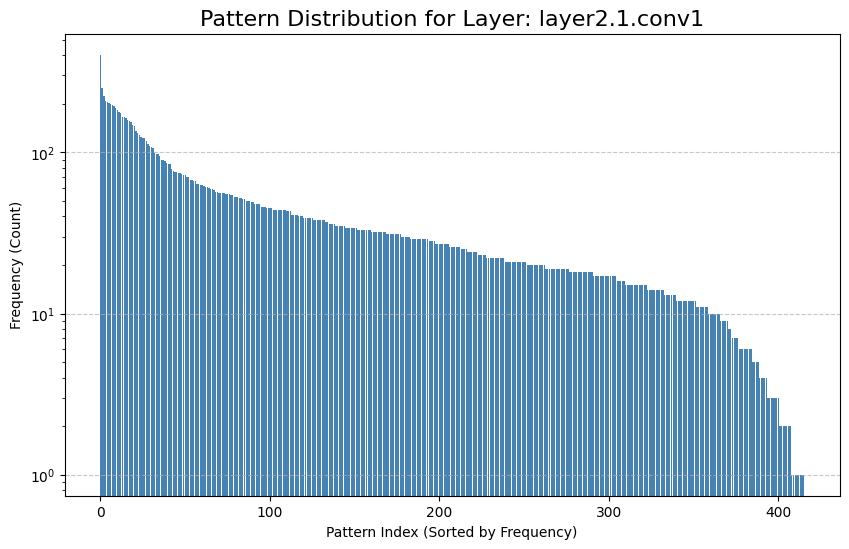

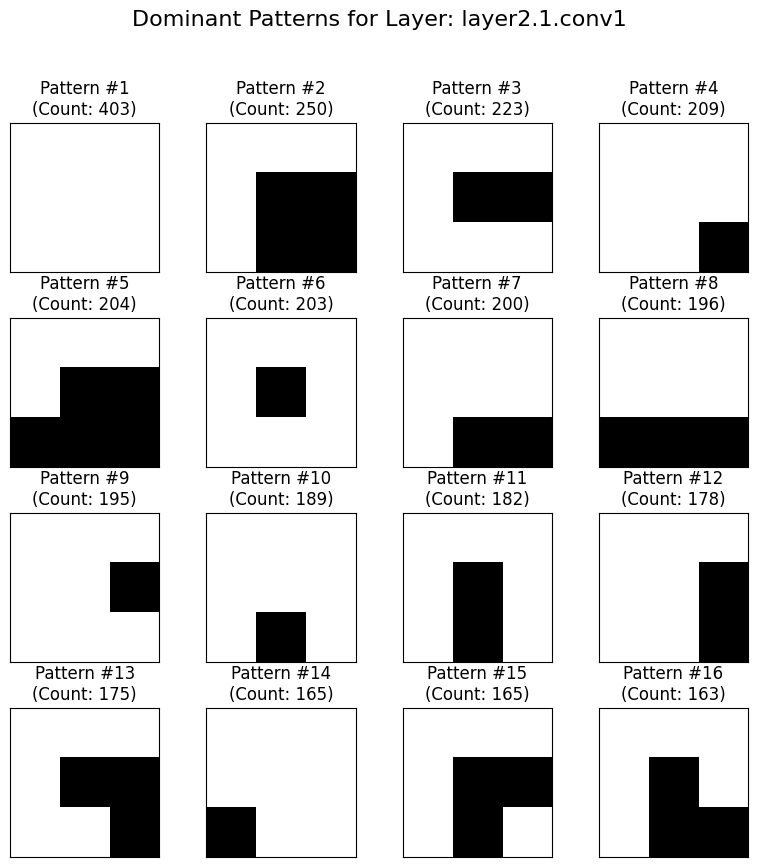

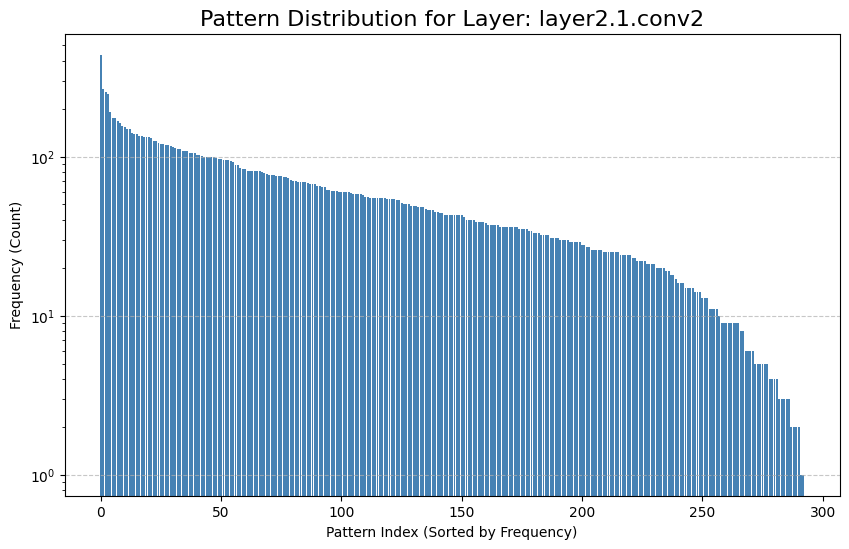

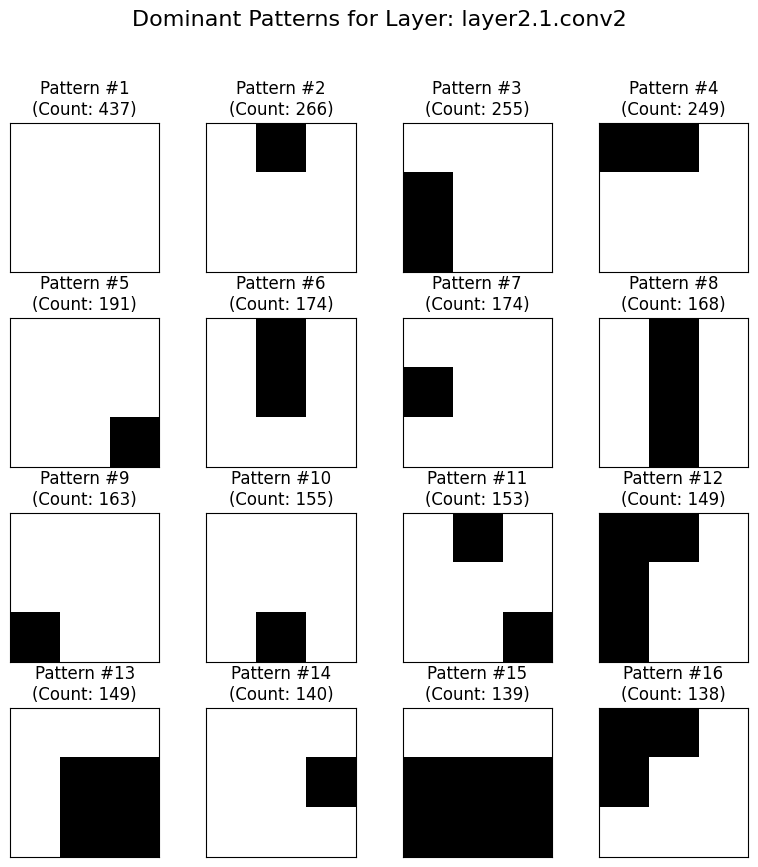

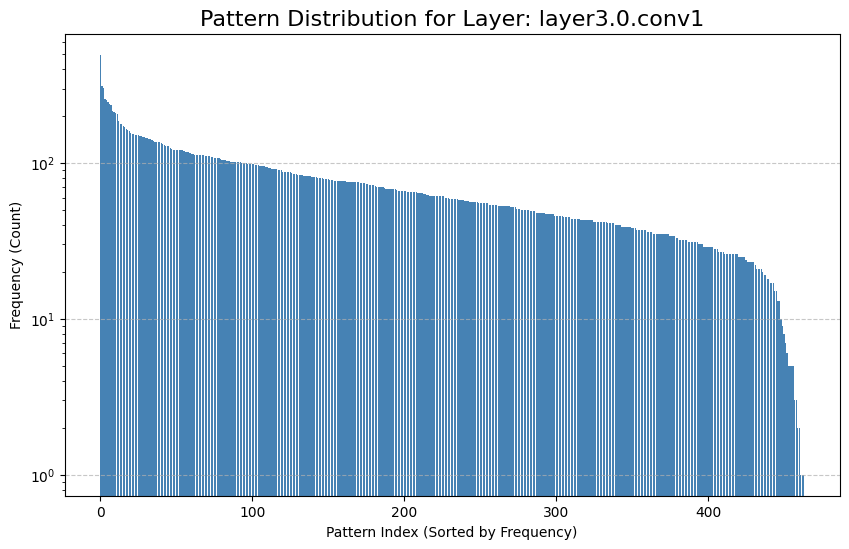

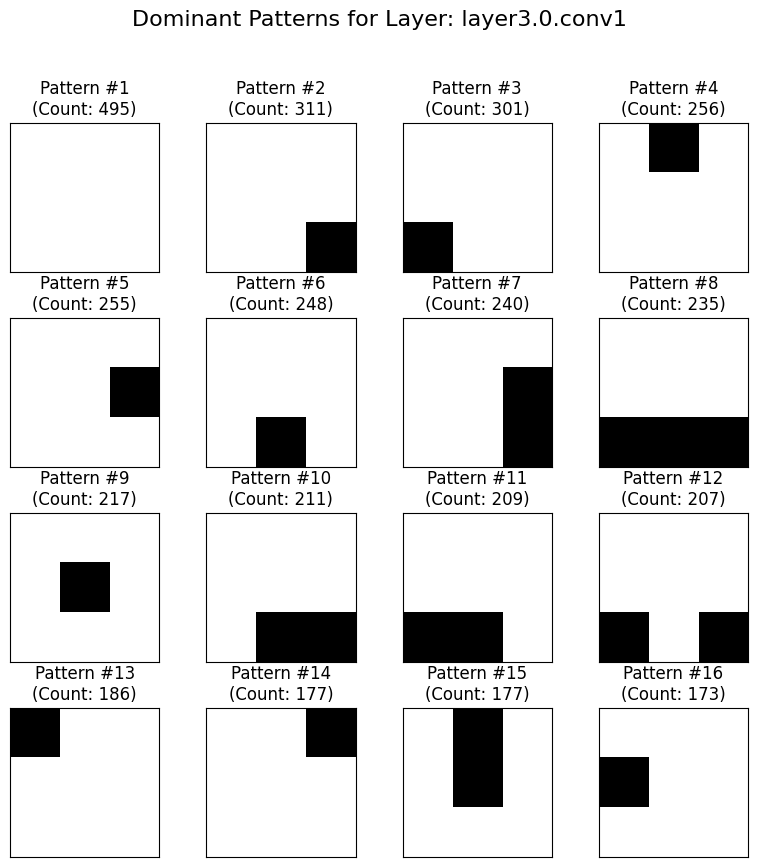

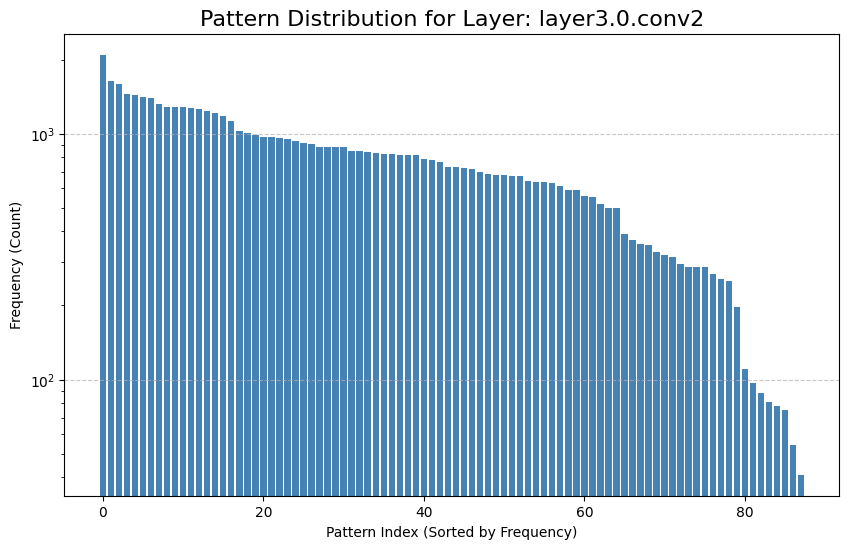

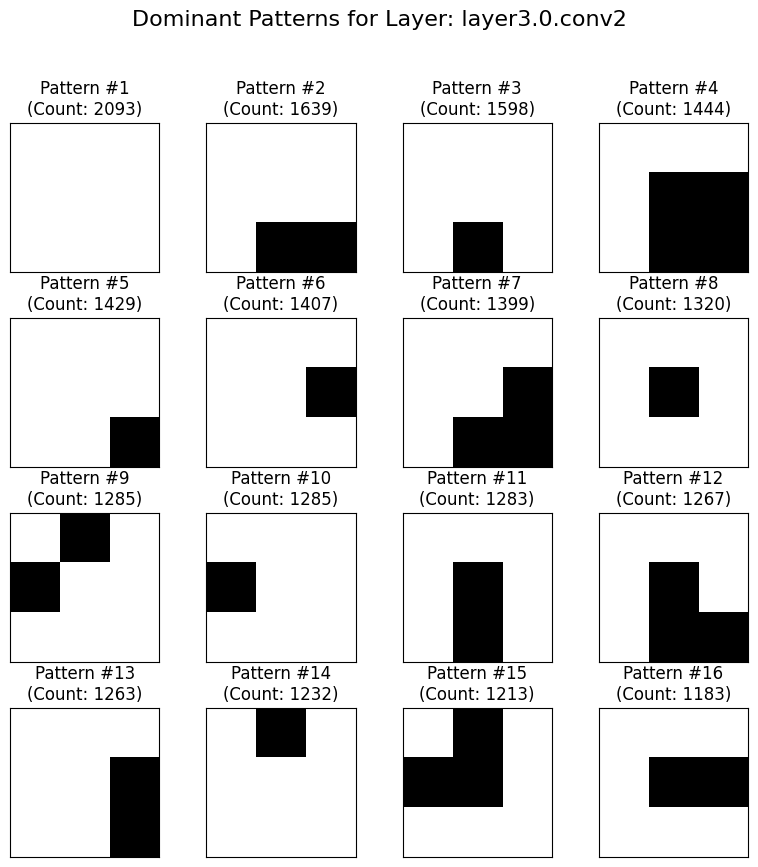

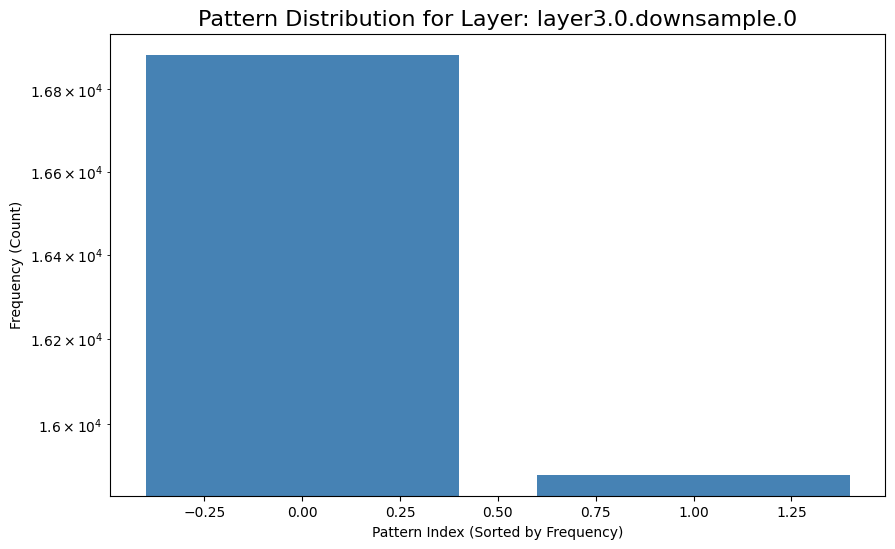

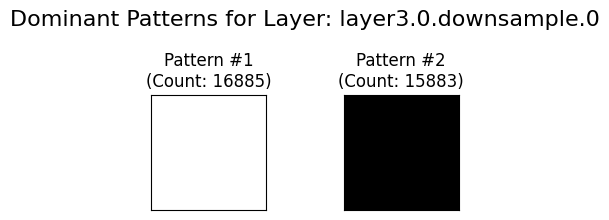

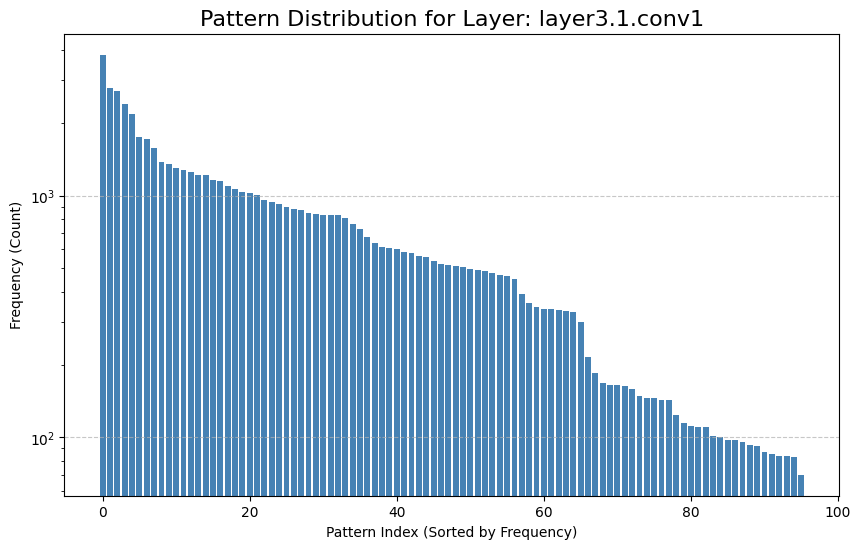

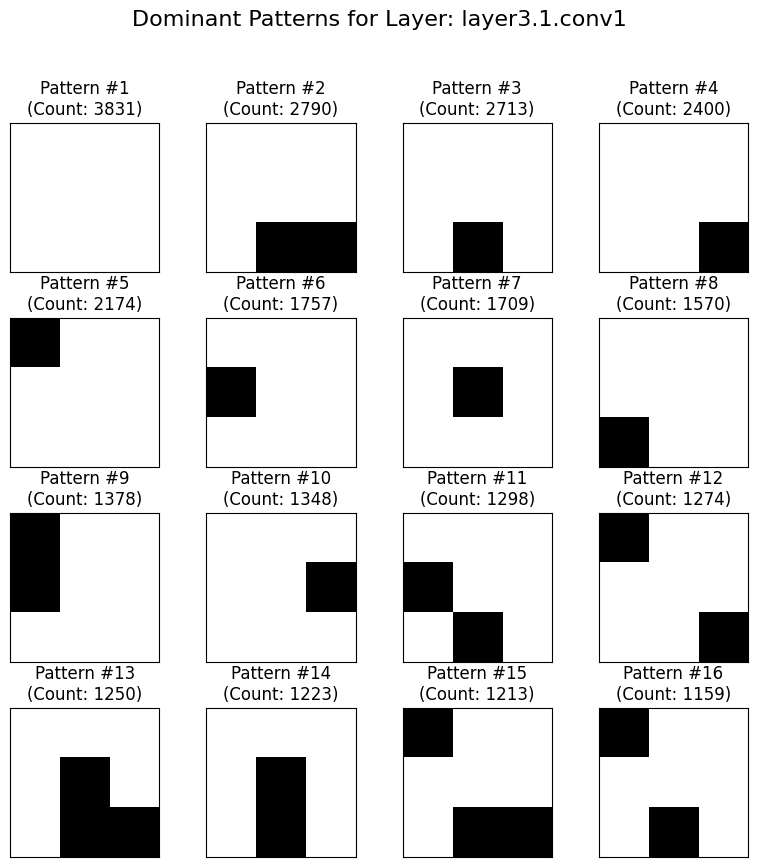

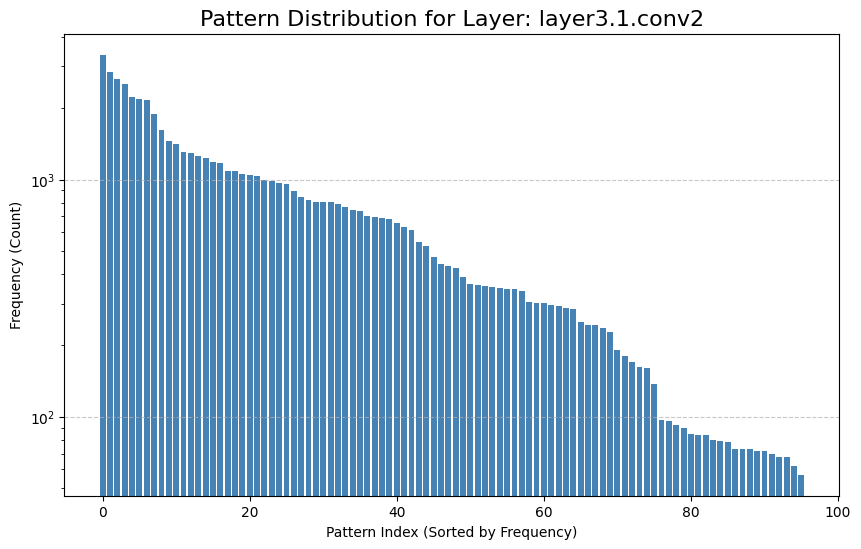

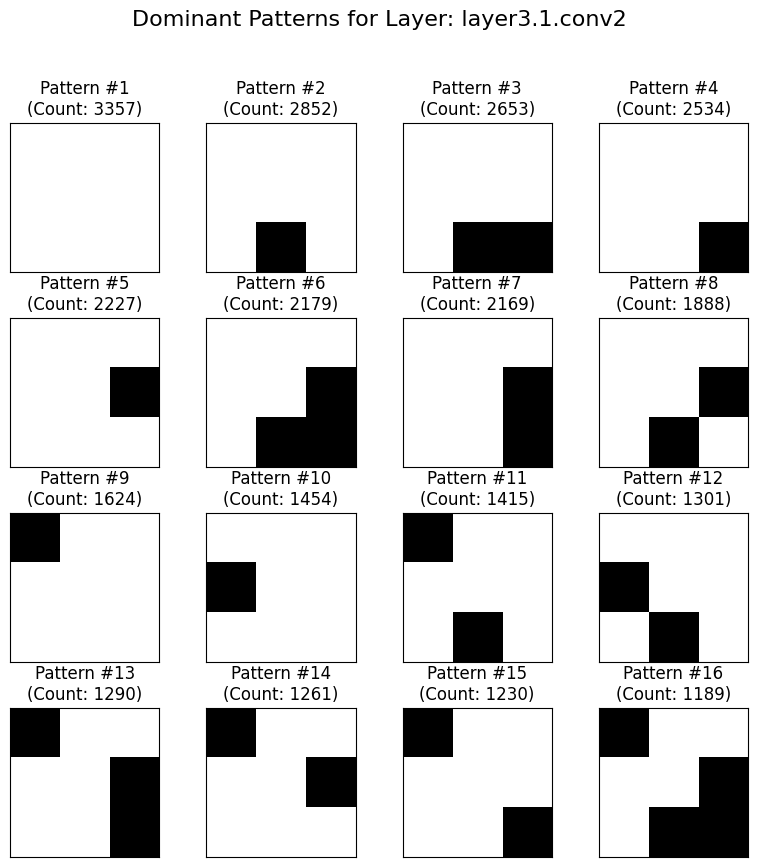

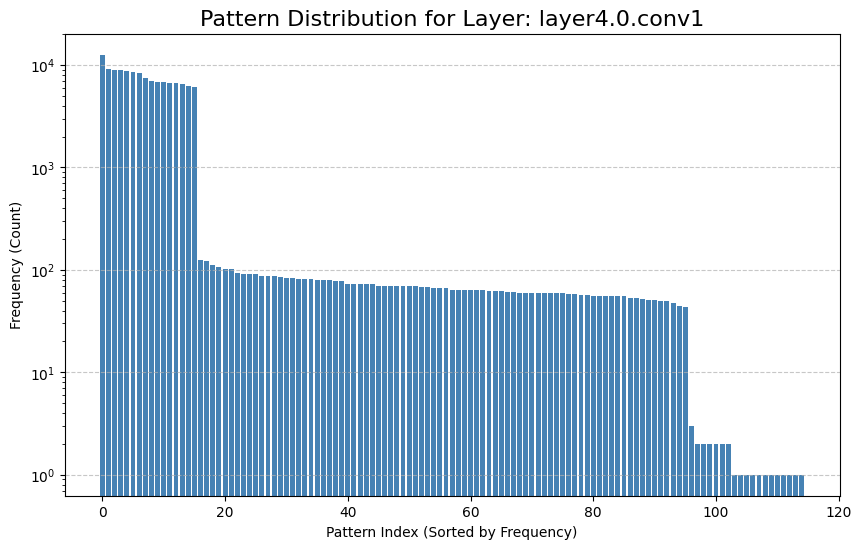

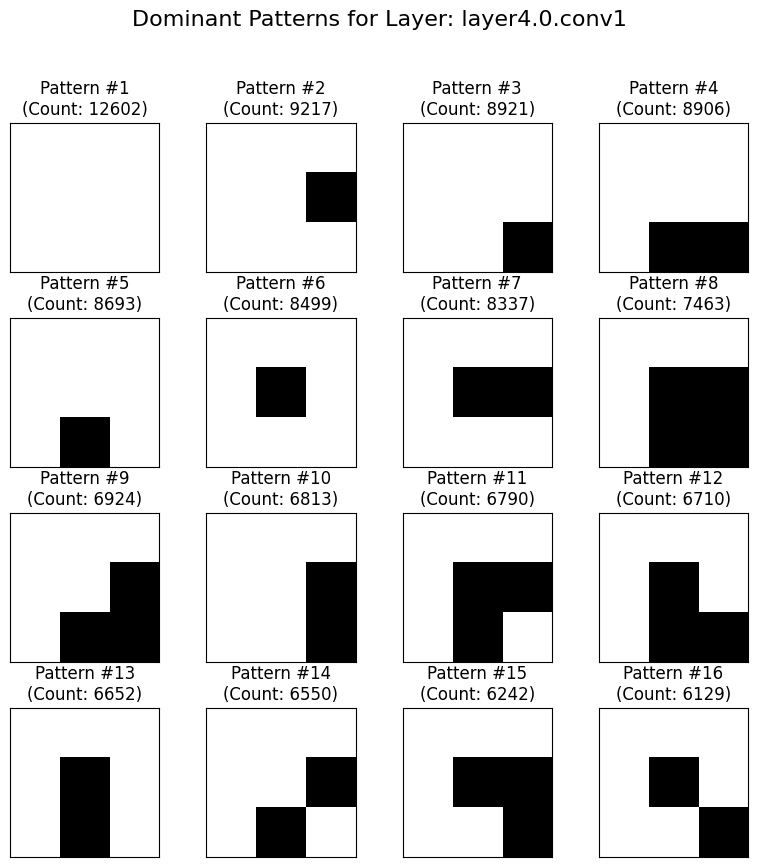

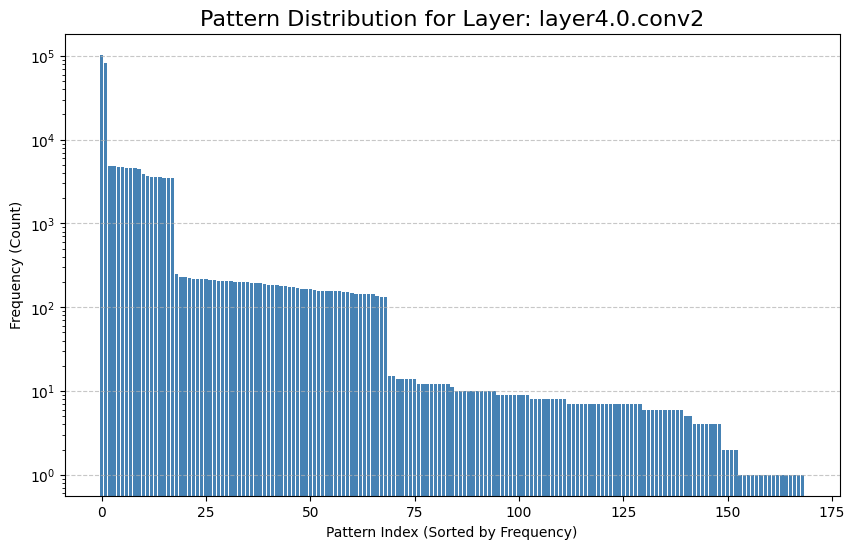

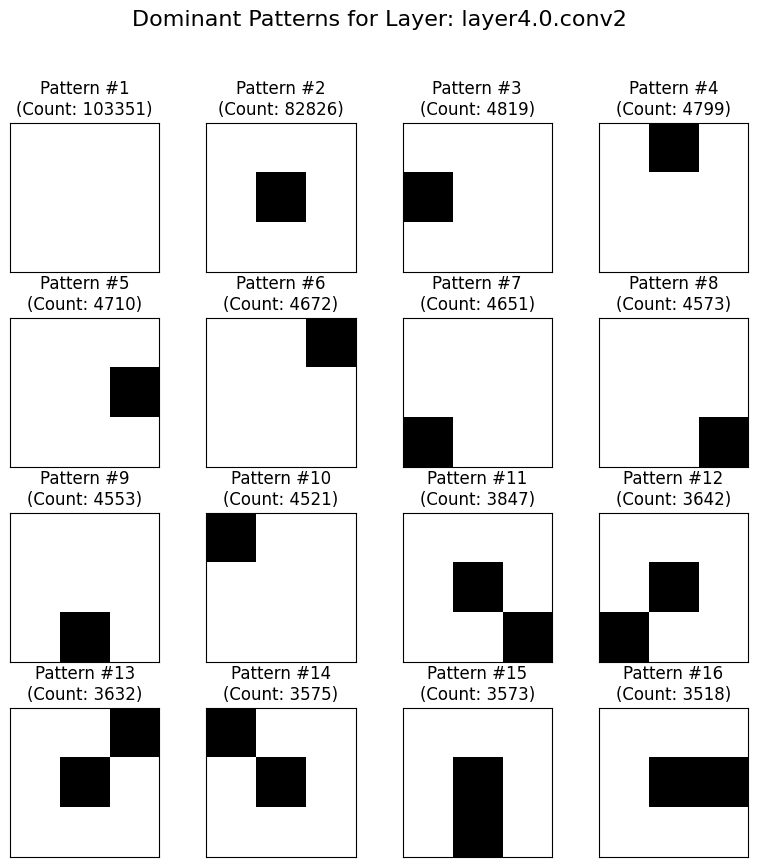

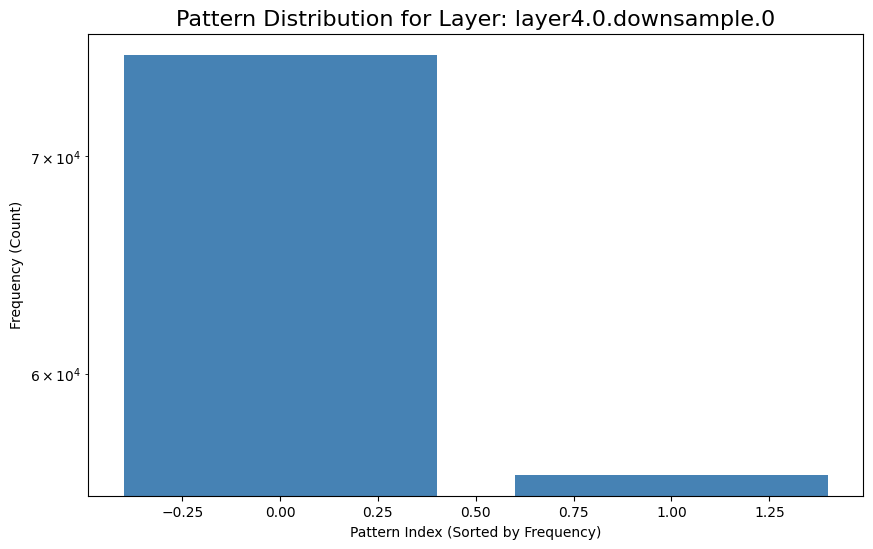

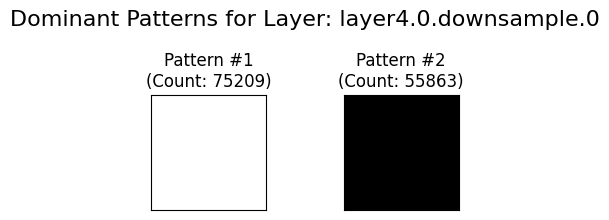

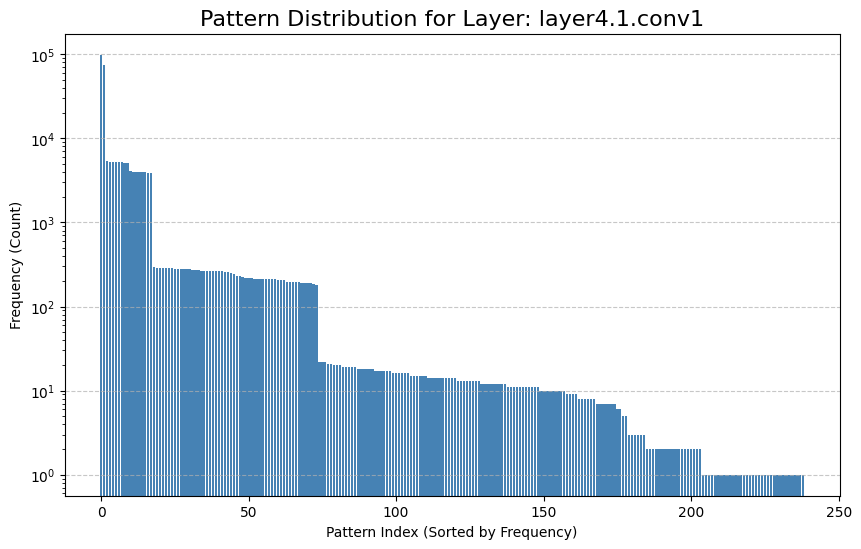

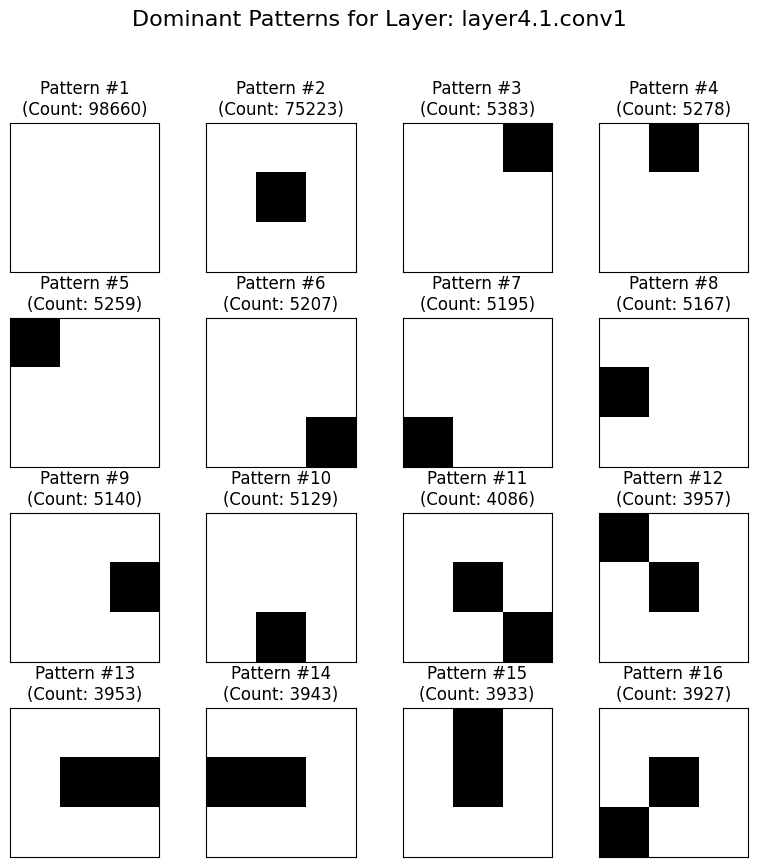

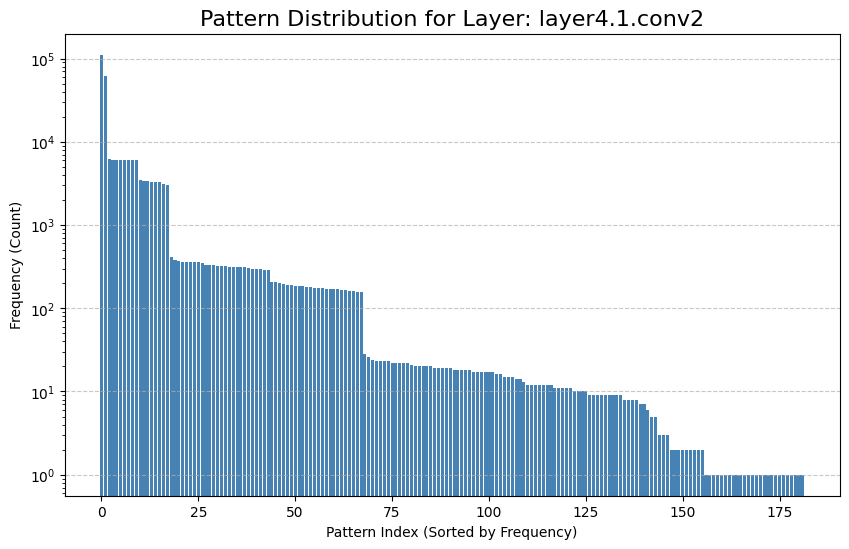

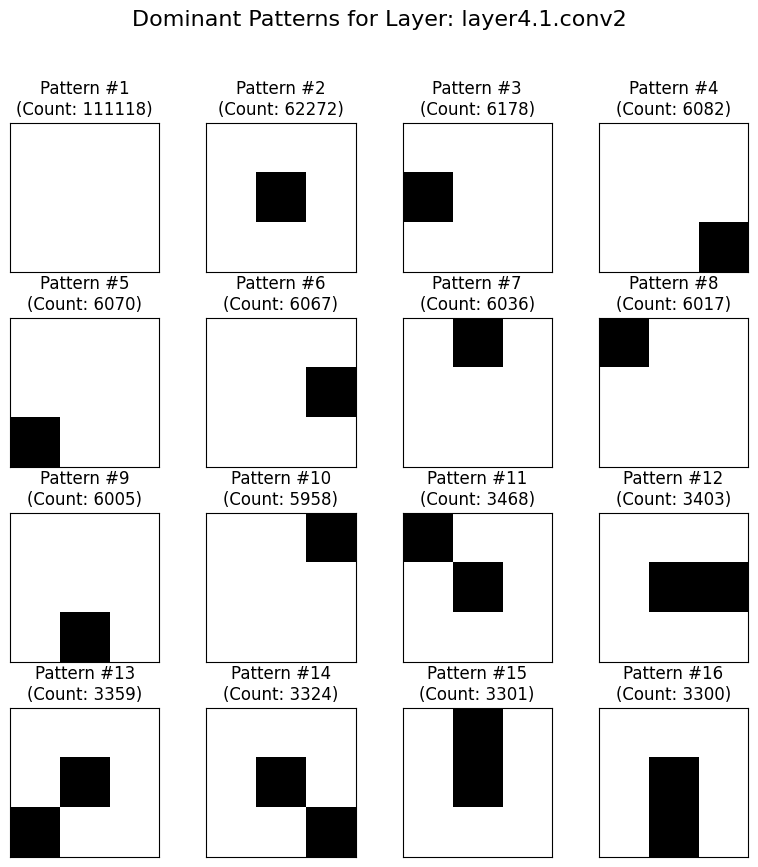

In [33]:

for layer_name, data in all_patterns.items():
    fig_hist = plot_pattern_distribution(layer_name, data)
    plt.show()
    
    fig_patterns = plot_dominant_patterns(layer_name, data)
    plt.show()